In [1]:
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from scipy.stats import spearmanr, pearsonr

import seaborn as sns

from basenji.gene import gtf_kv
from basenji import gene as bgene

from sklearn.metrics import average_precision_score, roc_auc_score

#Function require that a crispr row exists in both dataframes, or that it is beyond a certain distance from TSS
def intersect_or_beyond(crispr_df_1, crispr_df_2, distance_within=0) :
    
    #Get natural keys
    crispr_df_1['join_id'] = crispr_df_1['chr'] + '_' + crispr_df_1['start'].astype(str) + '_' + crispr_df_1['end'].astype(str) + '_' + crispr_df_1['gene'].astype(str)
    crispr_df_2['join_id'] = crispr_df_2['chr'] + '_' + crispr_df_2['start'].astype(str) + '_' + crispr_df_2['end'].astype(str) + '_' + crispr_df_2['gene'].astype(str)
    
    #Filter dataframe copies
    crispr_df_1_copy = crispr_df_1.loc[(crispr_df_1['tss_distance'] > distance_within) | (crispr_df_1['join_id'].isin(crispr_df_2['join_id'].values.tolist()))].copy()
    crispr_df_2_copy = crispr_df_2.loc[(crispr_df_2['tss_distance'] > distance_within) | (crispr_df_2['join_id'].isin(crispr_df_1['join_id'].values.tolist()))].copy()
    
    return crispr_df_1_copy, crispr_df_2_copy

#Function to compute accuracy stats for crispr benchmark
def accuracy_stats(crispr_df, n_bootstrap=1000, lo=0.025, hi=0.975, distance_boundaries=[0, 15000, 60000, 130000, 262144]) :
  
    col_names = ['dist', 'sites', 'pos', 'auc', 'ap', 'tss_auc', 'tss_ap', 'auc_lo', 'auc_med', 'auc_hi', 'ap_lo', 'ap_med', 'ap_hi']
    print('\t'.join(col_names))
    
    lines = []
    
    #Loop over distance boundaries
    for di in range(len(distance_boundaries) - 1) :
        
        #Apply distance filter
        distance_mask = (crispr_df.tss_distance > distance_boundaries[di])
        distance_mask &= (crispr_df.tss_distance <= distance_boundaries[di+1])
        dcrispr_df = crispr_df[distance_mask]

        #Get number of sites
        num_sites = dcrispr_df.shape[0]
        num_pos = dcrispr_df.regulate.sum()

        #Compute accuracies
        if num_sites < 2 or num_pos < 1 :
            auroc_model = np.nan
            auprc_model = np.nan
            auroc_tss = np.nan
            auprc_tss = np.nan

        else :
            auroc_model = roc_auc_score(dcrispr_df.regulate, dcrispr_df.score)
            auprc_model = average_precision_score(dcrispr_df.regulate, dcrispr_df.score)
            auroc_tss = roc_auc_score(dcrispr_df.regulate, 1./dcrispr_df.tss_distance)
            auprc_tss = average_precision_score(dcrispr_df.regulate, 1./dcrispr_df.tss_distance)
        
        #Estimate confidence interval by bootstrapping
        auroc_model_bootstrap = []
        auprc_model_bootstrap = []
        if n_bootstrap > 0 :
            
            #Loop over bootstrap samples
            for sample_ix in range(n_bootstrap) :
                
                #Resample data with replacement
                bootstrap_index = np.random.choice(np.arange(len(dcrispr_df)).tolist(), size=(len(dcrispr_df),), replace=True).tolist()
                dcrispr_df_bootstrap = dcrispr_df.iloc[bootstrap_index].copy()
                
                #Get number of sites
                num_sites_bootstrap = dcrispr_df_bootstrap.shape[0]
                num_pos_bootstrap = dcrispr_df_bootstrap.regulate.sum()

                #Compute accuracies
                if num_sites_bootstrap < 2 or num_pos_bootstrap < 1 :
                    auroc_model_bootstrap.append(np.nan)
                    auprc_model_bootstrap.append(np.nan)
                else :
                    auroc_model_bootstrap.append(roc_auc_score(dcrispr_df_bootstrap.regulate, dcrispr_df_bootstrap.score))
                    auprc_model_bootstrap.append(average_precision_score(dcrispr_df_bootstrap.regulate, dcrispr_df_bootstrap.score))
        
        auroc_model_lo = np.nan
        auroc_model_med = np.nan
        auroc_model_hi = np.nan
        auprc_model_lo = np.nan
        auprc_model_med = np.nan
        auprc_model_hi = np.nan
        if n_bootstrap > 0 :
            auroc_model_lo = np.quantile(auroc_model_bootstrap, q=lo)
            auroc_model_med = np.median(auroc_model_bootstrap)
            auroc_model_hi = np.quantile(auroc_model_bootstrap, q=hi)
            auprc_model_lo = np.quantile(auprc_model_bootstrap, q=lo)
            auprc_model_med = np.median(auprc_model_bootstrap)
            auprc_model_hi = np.quantile(auprc_model_bootstrap, q=hi)
        
        #Print accuracies
        cols = [str(distance_boundaries[di+1]), str(num_sites), str(num_pos)]
        cols += ['%.4f' % auroc_model, '%.4f' % auprc_model]
        cols += ['%.4f' % auroc_tss, '%.4f' % auprc_tss]
        cols += ['%.4f' % auroc_model_lo, '%.4f' % auroc_model_med, '%.4f' % auroc_model_hi]
        cols += ['%.4f' % auprc_model_lo, '%.4f' % auprc_model_med, '%.4f' % auprc_model_hi]
        
        lines.append('\t'.join(cols))
        
        print(lines[-1])
    
    #Create dataframe with stats
    stats_df = pd.DataFrame([li.split('\t') for li in lines], columns=col_names)
    
    return stats_df

#Function to compute fold change stats for crispr benchmark
def fc_stats(crispr_df, n_bootstrap=1000, lo=0.025, hi=0.975, distance_boundaries=[0, 15000, 60000, 130000, 262144]) :
  
    col_names = ['dist', 'sites', 'pos', 'fc', 'fc_lo', 'fc_med', 'fc_hi']
    print('\t'.join(col_names))
    
    lines = []
    
    #Loop over distance boundaries
    for di in range(len(distance_boundaries) - 1) :
        
        #Apply distance filter
        distance_mask = (crispr_df.tss_distance > distance_boundaries[di])
        distance_mask &= (crispr_df.tss_distance <= distance_boundaries[di+1])
        dcrispr_df = crispr_df[distance_mask]

        #Get number of sites
        num_sites = dcrispr_df.shape[0]
        num_pos = dcrispr_df.regulate.sum()

        #Compute accuracies
        if num_sites < 2 or num_pos < 1 :
            fc_model = np.nan
        else :
            fc_model = dcrispr_df.query("regulate == True")['pct_change'].abs().mean() / dcrispr_df.query("regulate == False")['pct_change'].abs().mean()
        
        #Estimate confidence interval by bootstrapping
        fc_model_bootstrap = []
        if n_bootstrap > 0 :
            
            #Loop over bootstrap samples
            for sample_ix in range(n_bootstrap) :
                
                #Resample data with replacement
                bootstrap_index = np.random.choice(np.arange(len(dcrispr_df)).tolist(), size=(len(dcrispr_df),), replace=True).tolist()
                dcrispr_df_bootstrap = dcrispr_df.iloc[bootstrap_index].copy()
                
                #Get number of sites
                num_sites_bootstrap = dcrispr_df_bootstrap.shape[0]
                num_pos_bootstrap = dcrispr_df_bootstrap.regulate.sum()

                #Compute accuracies
                if num_sites_bootstrap < 2 or num_pos_bootstrap < 1 :
                    fc_model_bootstrap.append(np.nan)
                else :
                    fc_model_bootstrap.append(dcrispr_df_bootstrap.query("regulate == True")['pct_change'].abs().mean() / dcrispr_df_bootstrap.query("regulate == False")['pct_change'].abs().mean())
        
        fc_model_lo = np.nan
        fc_model_med = np.nan
        fc_model_hi = np.nan
        if n_bootstrap > 0 :
            fc_model_lo = np.quantile(fc_model_bootstrap, q=lo)
            fc_model_med = np.median(fc_model_bootstrap)
            fc_model_hi = np.quantile(fc_model_bootstrap, q=hi)
        
        #Print accuracies
        cols = [str(distance_boundaries[di+1]), str(num_sites), str(num_pos)]
        cols += ['%.4f' % fc_model]
        cols += ['%.4f' % fc_model_lo, '%.4f' % fc_model_med, '%.4f' % fc_model_hi]
        
        lines.append('\t'.join(cols))
        
        print(lines[-1])
    
    #Create dataframe with stats
    stats_df = pd.DataFrame([li.split('\t') for li in lines], columns=col_names)
    
    return stats_df

#Function to plot barchart with model performance 
def plot_bars(model_names, model_dfs, model_colors, limit_x=False, legend_outside=False, model_hatches=None, fig_size=(8, 3), plot_title='FlowFISH - Gradients (gaussian)', metric='ap', metric_str='AUPRC', distances=[15000, 60000, 130000, 262000], distance_strs=['< 15kb', '15kb - 60kb', '60kb - 130kb', '130kb - 262kb'], y_min=0.0, y_max=1.0, save_name=None) : 
    
    n_models = len(model_names)
    n_distances = len(distances)

    f = plt.figure(figsize=fig_size, dpi=300)

    distances_x = np.arange(len(distances))

    #Loop over models
    for model_i in range(n_models) :

        #Plot metrics
        acc_val = np.array(model_dfs[model_i][metric].astype('float32').values, dtype='float32')
        acc_lo = np.array(model_dfs[model_i][metric + '_lo'].astype('float32').values, dtype='float32')
        acc_hi = np.array(model_dfs[model_i][metric + '_hi'].astype('float32').values, dtype='float32')

        hatch = None if model_hatches is None else model_hatches[model_i]
        
        plt.bar(distances_x * (n_models + 0.5) + model_i, acc_val, width=0.8, color=model_colors[model_i], hatch=hatch, label=model_names[model_i], edgecolor='black', linewidth=0.5)

        #Plot bootstrap confidence interval
        for distance_i in range(n_distances) :
            if acc_lo[distance_i] != acc_val[distance_i] and acc_hi[distance_i] != acc_val[distance_i] :

                x_mid = (distances_x * (n_models + 0.5) + model_i)[distance_i]
                acc_lo_val = acc_lo[distance_i]
                acc_hi_val = acc_hi[distance_i]

                plt.plot([x_mid - 0.35, x_mid + 0.35], [acc_lo_val, acc_lo_val], linewidth=0.5, linestyle='-', color='red')
                plt.plot([x_mid, x_mid], [acc_lo_val, acc_hi_val], linewidth=0.5, linestyle='--', color='red')
                plt.plot([x_mid - 0.35, x_mid + 0.35], [acc_hi_val, acc_hi_val], linewidth=0.5, linestyle='-', color='red')

    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)

    if limit_x :
        plt.xlim(-1.5, len(distances) * (n_models + 0.5))
    
    plt.xticks(distances_x * (n_models + 0.5) + n_models / 2. - 0.5, distance_strs, fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.ylabel(metric_str, fontsize=10)

    if not legend_outside :
        plt.legend(fontsize=8)
    else :
        plt.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=3)

    plt.title(plot_title, fontsize=10)

    plt.tight_layout()
    
    if save_name is not None :
        plt.savefig(save_name + '.eps')

    plt.show()


In [2]:
#Load dataframes

#Mini Borzoi gradients
crispr_df_miborzoi_baseline_grad_gaussian = pd.read_csv("site_scores_flowfish_k562_grad_miborzoi_baseline_ensemble_gaussian.csv", sep='\t')
crispr_df_miborzoi_human_all_grad_gaussian = pd.read_csv("site_scores_flowfish_k562_grad_miborzoi_human_all_ensemble_gaussian.csv", sep='\t')
crispr_df_miborzoi_human_dnase_atac_rna_grad_gaussian = pd.read_csv("site_scores_flowfish_k562_grad_miborzoi_human_dnase_atac_rna_ensemble_gaussian.csv", sep='\t')
crispr_df_miborzoi_k562_all_grad_gaussian = pd.read_csv("site_scores_flowfish_k562_grad_miborzoi_k562_all_ensemble_gaussian.csv", sep='\t')
crispr_df_miborzoi_k562_dnase_atac_rna_grad_gaussian = pd.read_csv("site_scores_flowfish_k562_grad_miborzoi_k562_dnase_atac_rna_ensemble_gaussian.csv", sep='\t')
crispr_df_miborzoi_k562_rna_grad_gaussian = pd.read_csv("site_scores_flowfish_k562_grad_miborzoi_k562_rna_ensemble_gaussian.csv", sep='\t')
crispr_df_miborzoi_multisp_dnase_atac_rna_grad_gaussian = pd.read_csv("site_scores_flowfish_k562_grad_miborzoi_multisp_dnase_atac_rna_ensemble_gaussian.csv", sep='\t')
crispr_df_miborzoi_multisp_rna_grad_gaussian = pd.read_csv("site_scores_flowfish_k562_grad_miborzoi_multisp_rna_ensemble_gaussian.csv", sep='\t')
crispr_df_miborzoi_multisp_no_unet_grad_gaussian = pd.read_csv("site_scores_flowfish_k562_grad_miborzoi_multisp_no_unet_ensemble_gaussian.csv", sep='\t')
crispr_df_borzoi_ensemble_grad_gaussian = pd.read_csv("site_scores_flowfish_k562_grad_borzoi_ensemble_gaussian.csv", sep='\t')

#Borzoi ism shuffles
crispr_df_miborzoi_baseline_ism = pd.read_csv("site_scores_flowfish_k562_ism_miborzoi_baseline_ensemble.csv", sep='\t')
crispr_df_miborzoi_human_all_ism = pd.read_csv("site_scores_flowfish_k562_ism_miborzoi_human_all_ensemble.csv", sep='\t')
crispr_df_miborzoi_human_dnase_atac_rna_ism = pd.read_csv("site_scores_flowfish_k562_ism_miborzoi_human_dnase_atac_rna_ensemble.csv", sep='\t')
crispr_df_miborzoi_k562_all_ism = pd.read_csv("site_scores_flowfish_k562_ism_miborzoi_k562_all_ensemble.csv", sep='\t')
crispr_df_miborzoi_k562_dnase_atac_rna_ism = pd.read_csv("site_scores_flowfish_k562_ism_miborzoi_k562_dnase_atac_rna_ensemble.csv", sep='\t')
crispr_df_miborzoi_k562_rna_ism = pd.read_csv("site_scores_flowfish_k562_ism_miborzoi_k562_rna_ensemble.csv", sep='\t')
crispr_df_miborzoi_multisp_dnase_atac_rna_ism = pd.read_csv("site_scores_flowfish_k562_ism_miborzoi_multisp_dnase_atac_rna_ensemble.csv", sep='\t')
crispr_df_miborzoi_multisp_rna_ism = pd.read_csv("site_scores_flowfish_k562_ism_miborzoi_multisp_rna_ensemble.csv", sep='\t')
crispr_df_miborzoi_multisp_no_unet_ism = pd.read_csv("site_scores_flowfish_k562_ism_miborzoi_multisp_no_unet_ensemble.csv", sep='\t')
crispr_df_borzoi_ensemble_ism = pd.read_csv("site_scores_flowfish_k562_ism_borzoi_ensemble.csv", sep='\t')

#Apply intersections and filter crispr rows

distance_within = 98000

#Gradients (gaussian)
crispr_df_miborzoi_baseline_grad_gaussian, crispr_df_miborzoi_human_all_grad_gaussian = intersect_or_beyond(crispr_df_miborzoi_baseline_grad_gaussian, crispr_df_miborzoi_human_all_grad_gaussian, distance_within=distance_within)
crispr_df_miborzoi_human_dnase_atac_rna_grad_gaussian, _ = intersect_or_beyond(crispr_df_miborzoi_human_dnase_atac_rna_grad_gaussian, crispr_df_miborzoi_baseline_grad_gaussian, distance_within=distance_within)
crispr_df_miborzoi_k562_all_grad_gaussian, _ = intersect_or_beyond(crispr_df_miborzoi_k562_all_grad_gaussian, crispr_df_miborzoi_baseline_grad_gaussian, distance_within=distance_within)
crispr_df_miborzoi_k562_dnase_atac_rna_grad_gaussian, _ = intersect_or_beyond(crispr_df_miborzoi_k562_dnase_atac_rna_grad_gaussian, crispr_df_miborzoi_baseline_grad_gaussian, distance_within=distance_within)
crispr_df_miborzoi_k562_rna_grad_gaussian, _ = intersect_or_beyond(crispr_df_miborzoi_k562_rna_grad_gaussian, crispr_df_miborzoi_baseline_grad_gaussian, distance_within=distance_within)
crispr_df_miborzoi_multisp_dnase_atac_rna_grad_gaussian, _ = intersect_or_beyond(crispr_df_miborzoi_multisp_dnase_atac_rna_grad_gaussian, crispr_df_miborzoi_baseline_grad_gaussian, distance_within=distance_within)
crispr_df_miborzoi_multisp_rna_grad_gaussian, _ = intersect_or_beyond(crispr_df_miborzoi_multisp_rna_grad_gaussian, crispr_df_miborzoi_baseline_grad_gaussian, distance_within=distance_within)
crispr_df_miborzoi_multisp_no_unet_grad_gaussian, _ = intersect_or_beyond(crispr_df_miborzoi_multisp_no_unet_grad_gaussian, crispr_df_miborzoi_baseline_grad_gaussian, distance_within=distance_within)
crispr_df_borzoi_ensemble_grad_gaussian, _ = intersect_or_beyond(crispr_df_borzoi_ensemble_grad_gaussian, crispr_df_miborzoi_baseline_grad_gaussian, distance_within=distance_within)

#ISM Shuffle
crispr_df_miborzoi_baseline_ism, crispr_df_miborzoi_human_all_ism = intersect_or_beyond(crispr_df_miborzoi_baseline_ism, crispr_df_miborzoi_human_all_ism, distance_within=distance_within)
crispr_df_miborzoi_human_dnase_atac_rna_ism, _ = intersect_or_beyond(crispr_df_miborzoi_human_dnase_atac_rna_ism, crispr_df_miborzoi_baseline_ism, distance_within=distance_within)
crispr_df_miborzoi_k562_all_ism, _ = intersect_or_beyond(crispr_df_miborzoi_k562_all_ism, crispr_df_miborzoi_baseline_ism, distance_within=distance_within)
crispr_df_miborzoi_k562_dnase_atac_rna_ism, _ = intersect_or_beyond(crispr_df_miborzoi_k562_dnase_atac_rna_ism, crispr_df_miborzoi_baseline_ism, distance_within=distance_within)
crispr_df_miborzoi_k562_rna_ism, _ = intersect_or_beyond(crispr_df_miborzoi_k562_rna_ism, crispr_df_miborzoi_baseline_ism, distance_within=distance_within)
crispr_df_miborzoi_multisp_dnase_atac_rna_ism, _ = intersect_or_beyond(crispr_df_miborzoi_multisp_dnase_atac_rna_ism, crispr_df_miborzoi_baseline_ism, distance_within=distance_within)
crispr_df_miborzoi_multisp_rna_ism, _ = intersect_or_beyond(crispr_df_miborzoi_multisp_rna_ism, crispr_df_miborzoi_baseline_ism, distance_within=distance_within)
crispr_df_miborzoi_multisp_no_unet_ism, _ = intersect_or_beyond(crispr_df_miborzoi_multisp_no_unet_ism, crispr_df_miborzoi_baseline_ism, distance_within=distance_within)
crispr_df_borzoi_ensemble_ism, _ = intersect_or_beyond(crispr_df_borzoi_ensemble_ism, crispr_df_miborzoi_baseline_ism, distance_within=distance_within)


In [3]:
#Evaluate mini borzoi scores (gradients; ensemble; gaussian)

print("-- mini borzoi scores (grad; baseline) --")

#Compute and print accuracy stats
stats_df_miborzoi_baseline_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_baseline_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- mini borzoi scores (grad; human_all) --")

#Compute and print accuracy stats
stats_df_miborzoi_human_all_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_human_all_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- mini borzoi scores (grad; human_dnase_atac_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_human_dnase_atac_rna_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_human_dnase_atac_rna_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- mini borzoi scores (grad; k562_all) --")

#Compute and print accuracy stats
stats_df_miborzoi_k562_all_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_k562_all_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- mini borzoi scores (grad; k562_dnase_atac_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_k562_dnase_atac_rna_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_k562_dnase_atac_rna_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- mini borzoi scores (grad; k562_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_k562_rna_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_k562_rna_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- mini borzoi scores (grad; multisp_dnase_atac_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_multisp_dnase_atac_rna_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_multisp_dnase_atac_rna_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- mini borzoi scores (grad; multisp_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_multisp_rna_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_multisp_rna_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- mini borzoi scores (grad; multisp_no_unet) --")

#Compute and print accuracy stats
stats_df_miborzoi_multisp_no_unet_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_multisp_no_unet_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- borzoi scores (grad) --")

#Compute and print accuracy stats
stats_df_borzoi_grad_gaussian = accuracy_stats(
    crispr_df_borzoi_ensemble_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)


-- mini borzoi scores (grad; baseline) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	141	47	0.8490	0.7678	0.7813	0.6390	0.7815	0.8520	0.9076	0.6503	0.7756	0.8696
45000	273	40	0.6862	0.4275	0.6536	0.2204	0.5895	0.6851	0.7739	0.2892	0.4339	0.5661
98000	510	14	0.6247	0.0401	0.5075	0.0402	0.4942	0.6261	0.7527	0.0210	0.0436	0.0757
196608	775	5	0.7829	0.0479	0.5745	0.0102	nan	nan	nan	nan	nan	nan
-- mini borzoi scores (grad; human_all) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	141	47	0.8701	0.7906	0.7813	0.6390	0.8152	0.8717	0.9245	0.6862	0.7964	0.8795
45000	273	40	0.7721	0.5229	0.6536	0.2204	0.6888	0.7734	0.8530	0.3838	0.5248	0.6595
98000	510	14	0.6456	0.0643	0.5075	0.0402	0.5060	0.6490	0.7675	0.0224	0.0676	0.2124
196608	775	5	0.6984	0.2261	0.5745	0.0102	nan	nan	nan	nan	nan	nan
-- mini borzoi scores (grad; human_dnase_atac_rna) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi

-- mini borzoi scores (ism shuffle; baseline) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	141	47	0.8373	0.8024	0.7813	0.6390	0.7542	0.8380	0.9098	0.6905	0.8075	0.8875
45000	273	40	0.6992	0.4430	0.6536	0.2204	0.5999	0.7022	0.7852	0.2967	0.4532	0.5804
98000	510	14	0.5953	0.0928	0.5075	0.0402	0.4149	0.5941	0.7751	0.0273	0.1053	0.2711
196608	775	5	0.7192	0.0291	0.5745	0.0102	nan	nan	nan	nan	nan	nan
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	141	47	4.5252	3.2022	4.5115	6.0752
45000	273	40	3.7662	2.2273	3.7446	5.7920
98000	510	14	2.0028	0.8484	1.9539	3.3378
196608	775	5	2.2499	nan	nan	nan


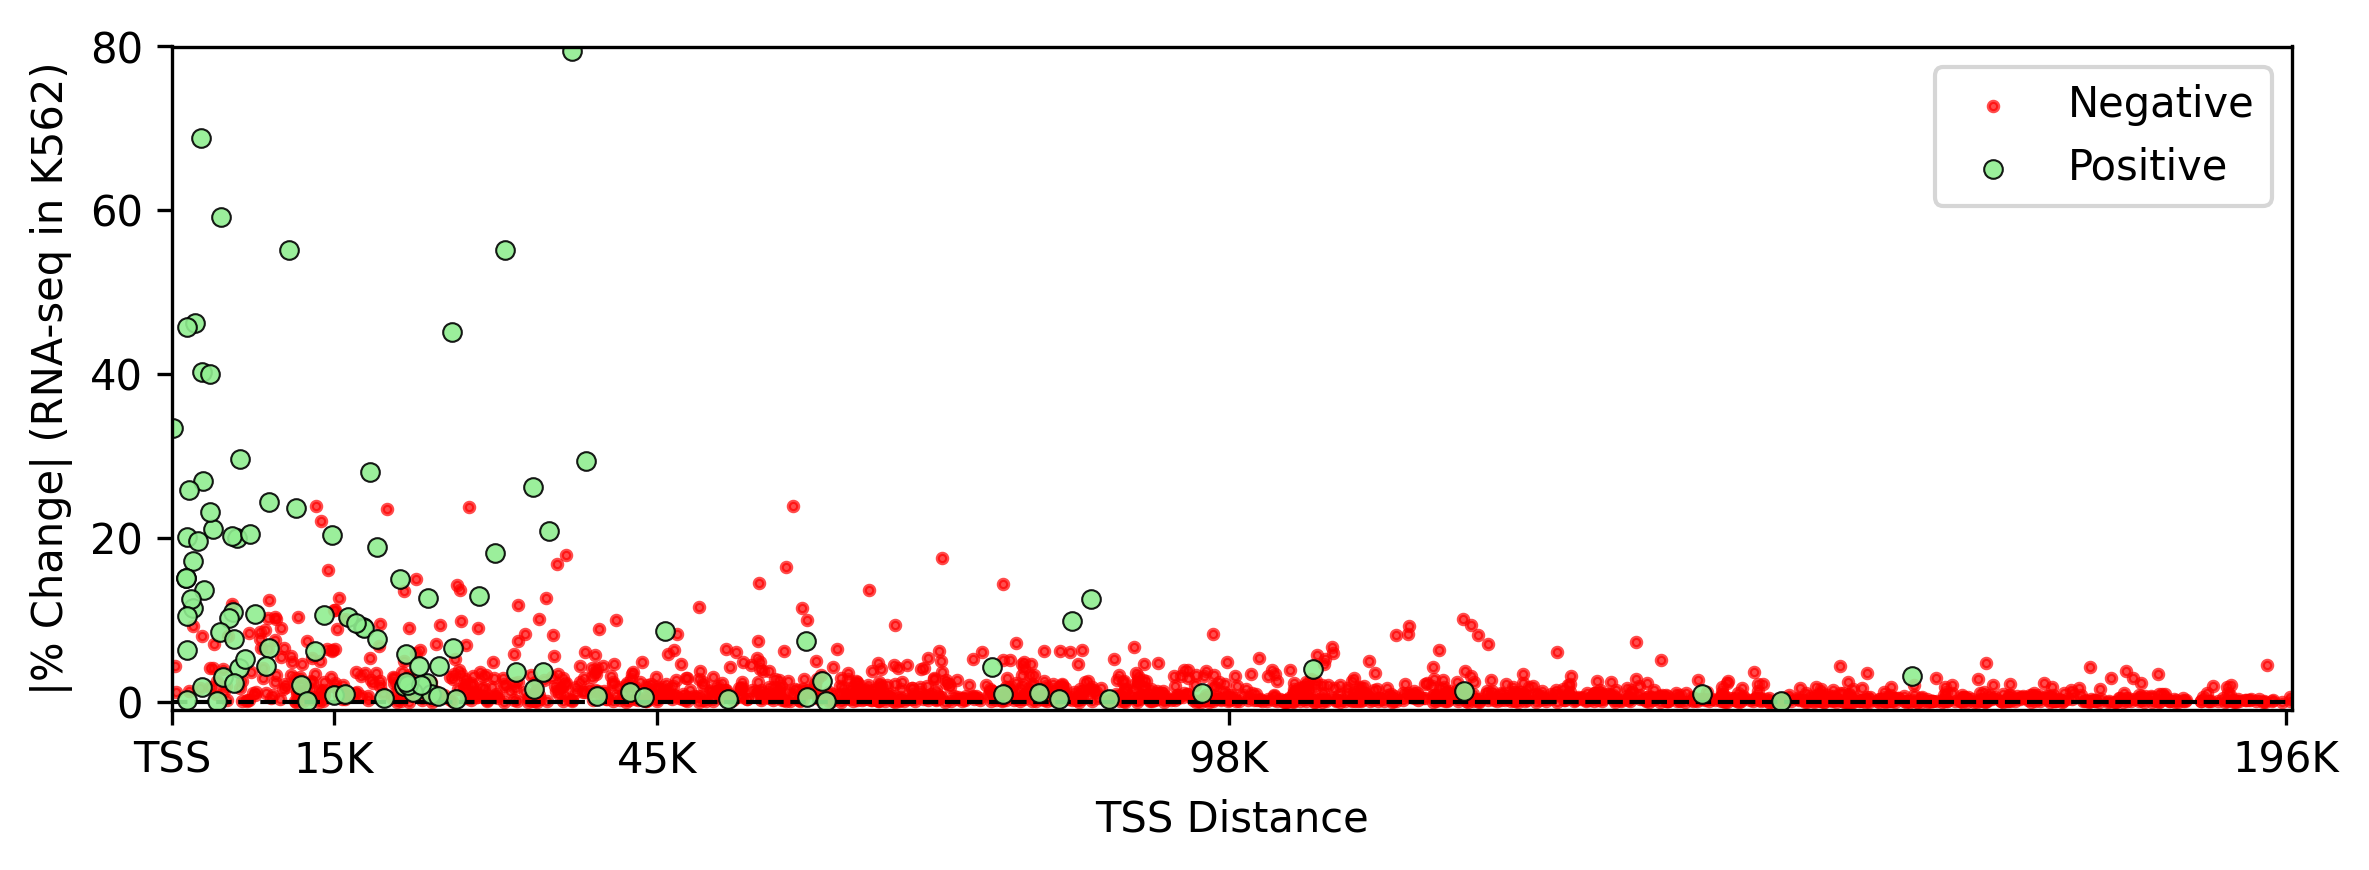

In [4]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; baseline) --")

#Compute and print accuracy stats
stats_df_miborzoi_baseline_ism = accuracy_stats(
    crispr_df_miborzoi_baseline_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_baseline_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_baseline_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- mini borzoi scores (ism shuffle; human_all) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	141	47	0.7711	0.6973	0.7813	0.6390	0.6711	0.7718	0.8555	0.5621	0.7056	0.8107
45000	273	40	0.6727	0.3932	0.6536	0.2204	0.5621	0.6730	0.7768	0.2472	0.3998	0.5521
98000	510	14	0.4427	0.0456	0.5075	0.0402	0.2707	0.4385	0.6317	0.0154	0.0491	0.1592
196608	775	5	0.5990	0.0093	0.5745	0.0102	nan	nan	nan	nan	nan	nan
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	141	47	3.5888	2.4333	3.6684	5.3551
45000	273	40	3.4362	1.9773	3.3920	5.3703
98000	510	14	1.2238	0.3533	1.1300	2.4165
196608	775	5	0.6881	nan	nan	nan


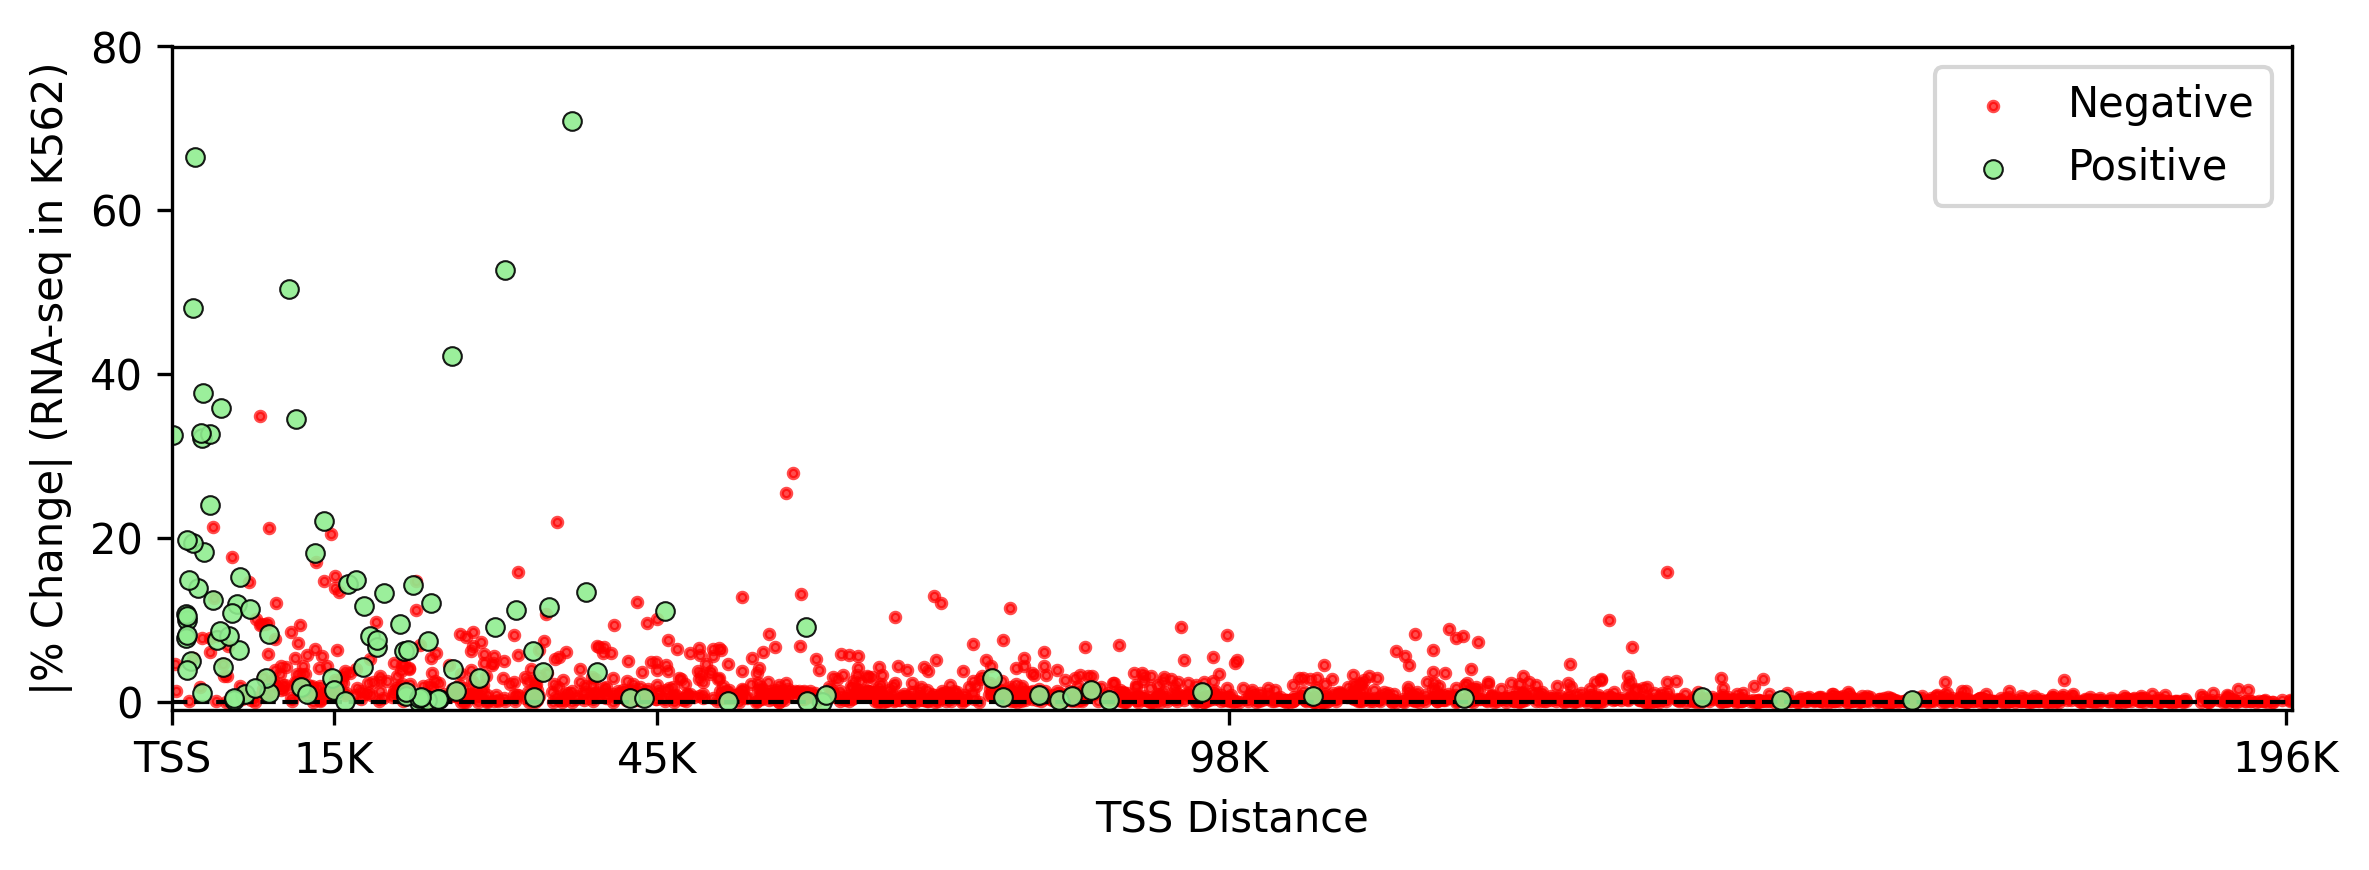

In [5]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; human_all) --")

#Compute and print accuracy stats
stats_df_miborzoi_human_all_ism = accuracy_stats(
    crispr_df_miborzoi_human_all_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_human_all_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_human_all_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- mini borzoi scores (ism shuffle; human_dnase_atac_rna) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	141	47	0.6347	0.5694	0.7813	0.6390	0.5275	0.6369	0.7294	0.4221	0.5740	0.6942
45000	273	40	0.6352	0.3541	0.6536	0.2204	0.5230	0.6336	0.7418	0.2235	0.3588	0.4977
98000	510	14	0.5791	0.0963	0.5075	0.0402	0.4069	0.5752	0.7543	0.0278	0.1053	0.2753
196608	775	5	0.5801	0.0157	0.5745	0.0102	nan	nan	nan	nan	nan	nan
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	141	47	2.5192	1.5742	2.4788	3.9183
45000	273	40	2.6449	1.5989	2.5735	4.0550
98000	510	14	2.2478	0.8173	2.2081	4.2241
196608	775	5	1.4641	nan	nan	nan


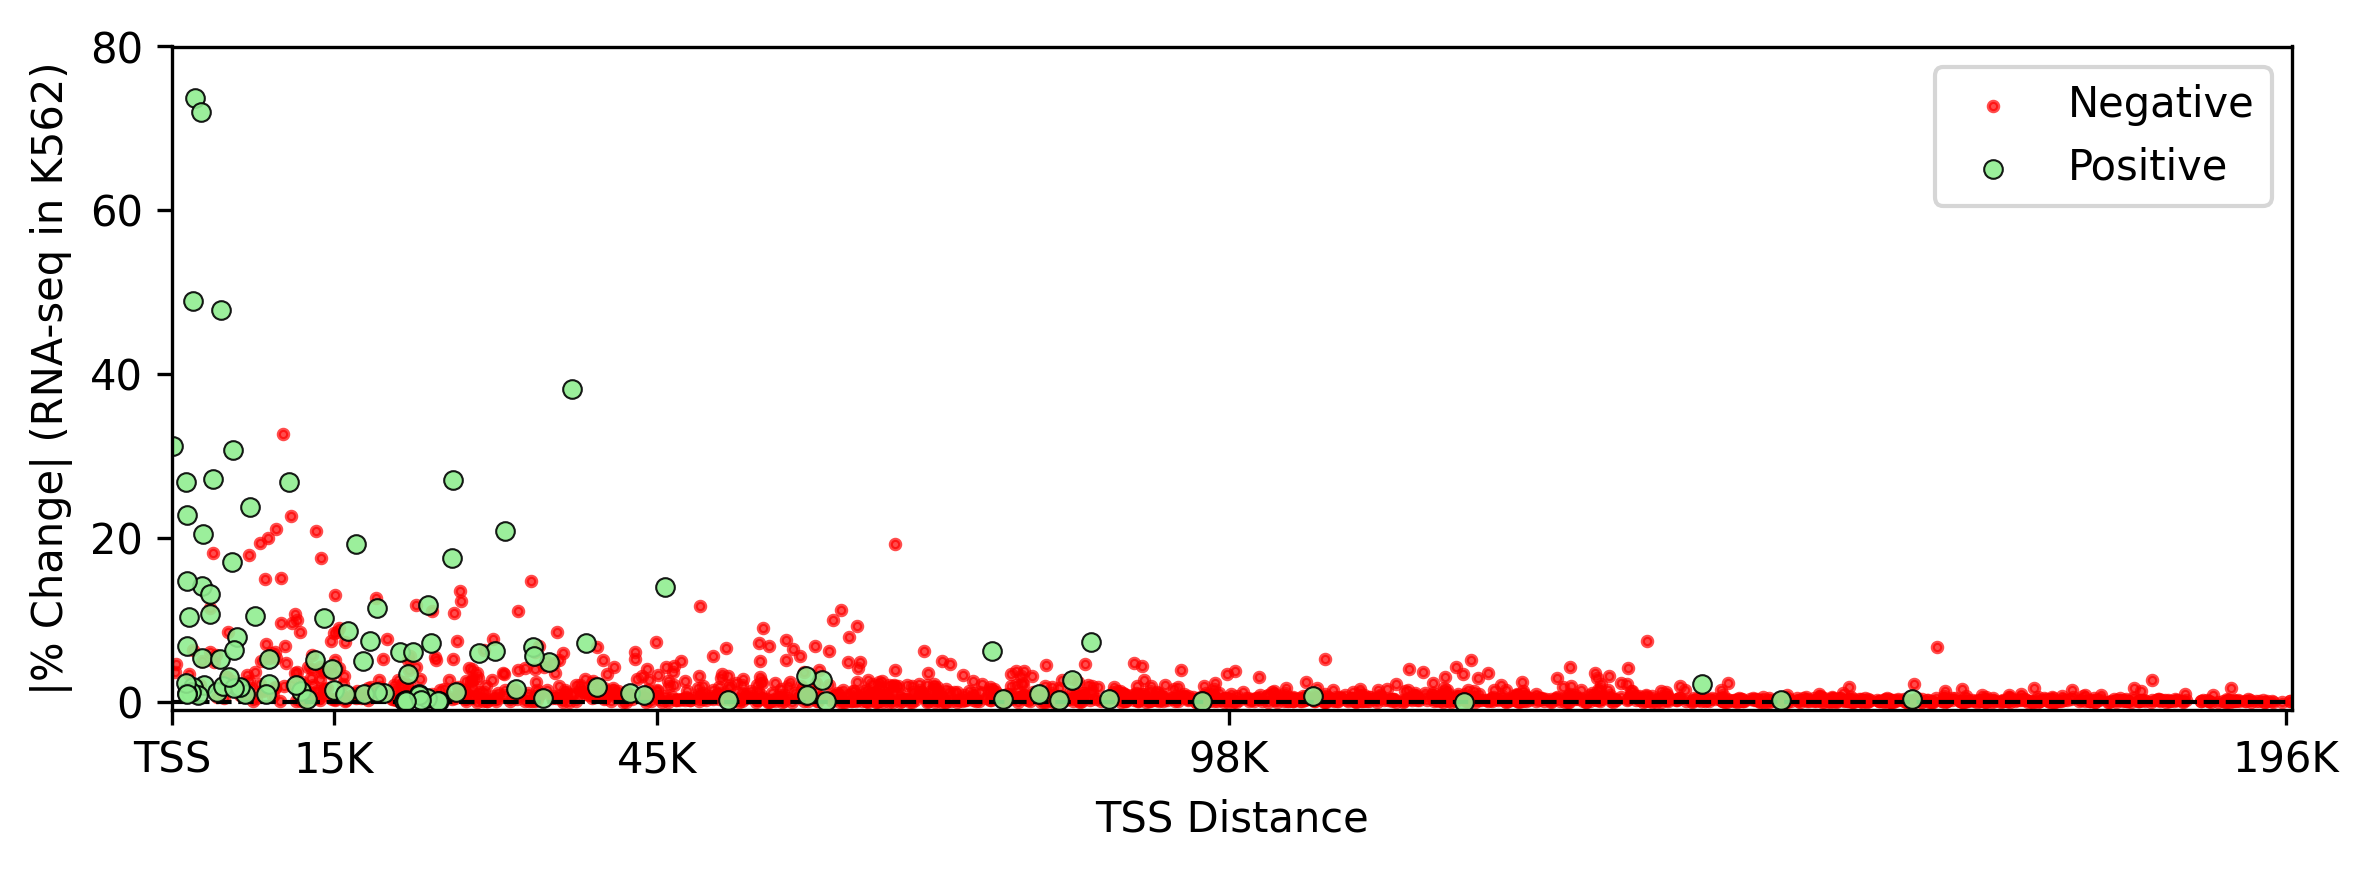

In [6]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; human_dnase_atac_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_human_dnase_atac_rna_ism = accuracy_stats(
    crispr_df_miborzoi_human_dnase_atac_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_human_dnase_atac_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_human_dnase_atac_rna_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- mini borzoi scores (ism shuffle; k562_all) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	141	47	0.6967	0.6018	0.7813	0.6390	0.5918	0.6976	0.7914	0.4573	0.6079	0.7297
45000	273	40	0.6704	0.3300	0.6536	0.2204	0.5807	0.6691	0.7563	0.2098	0.3359	0.4627
98000	510	14	0.7882	0.2133	0.5075	0.0402	0.6258	0.7985	0.9130	0.0718	0.2385	0.5000
196608	775	5	0.6982	0.2135	0.5745	0.0102	nan	nan	nan	nan	nan	nan
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	141	47	2.8958	1.7918	2.9295	4.3337
45000	273	40	2.4199	1.3813	2.3503	3.7954
98000	510	14	4.2023	2.0219	4.1230	6.6941
196608	775	5	3.2331	nan	nan	nan


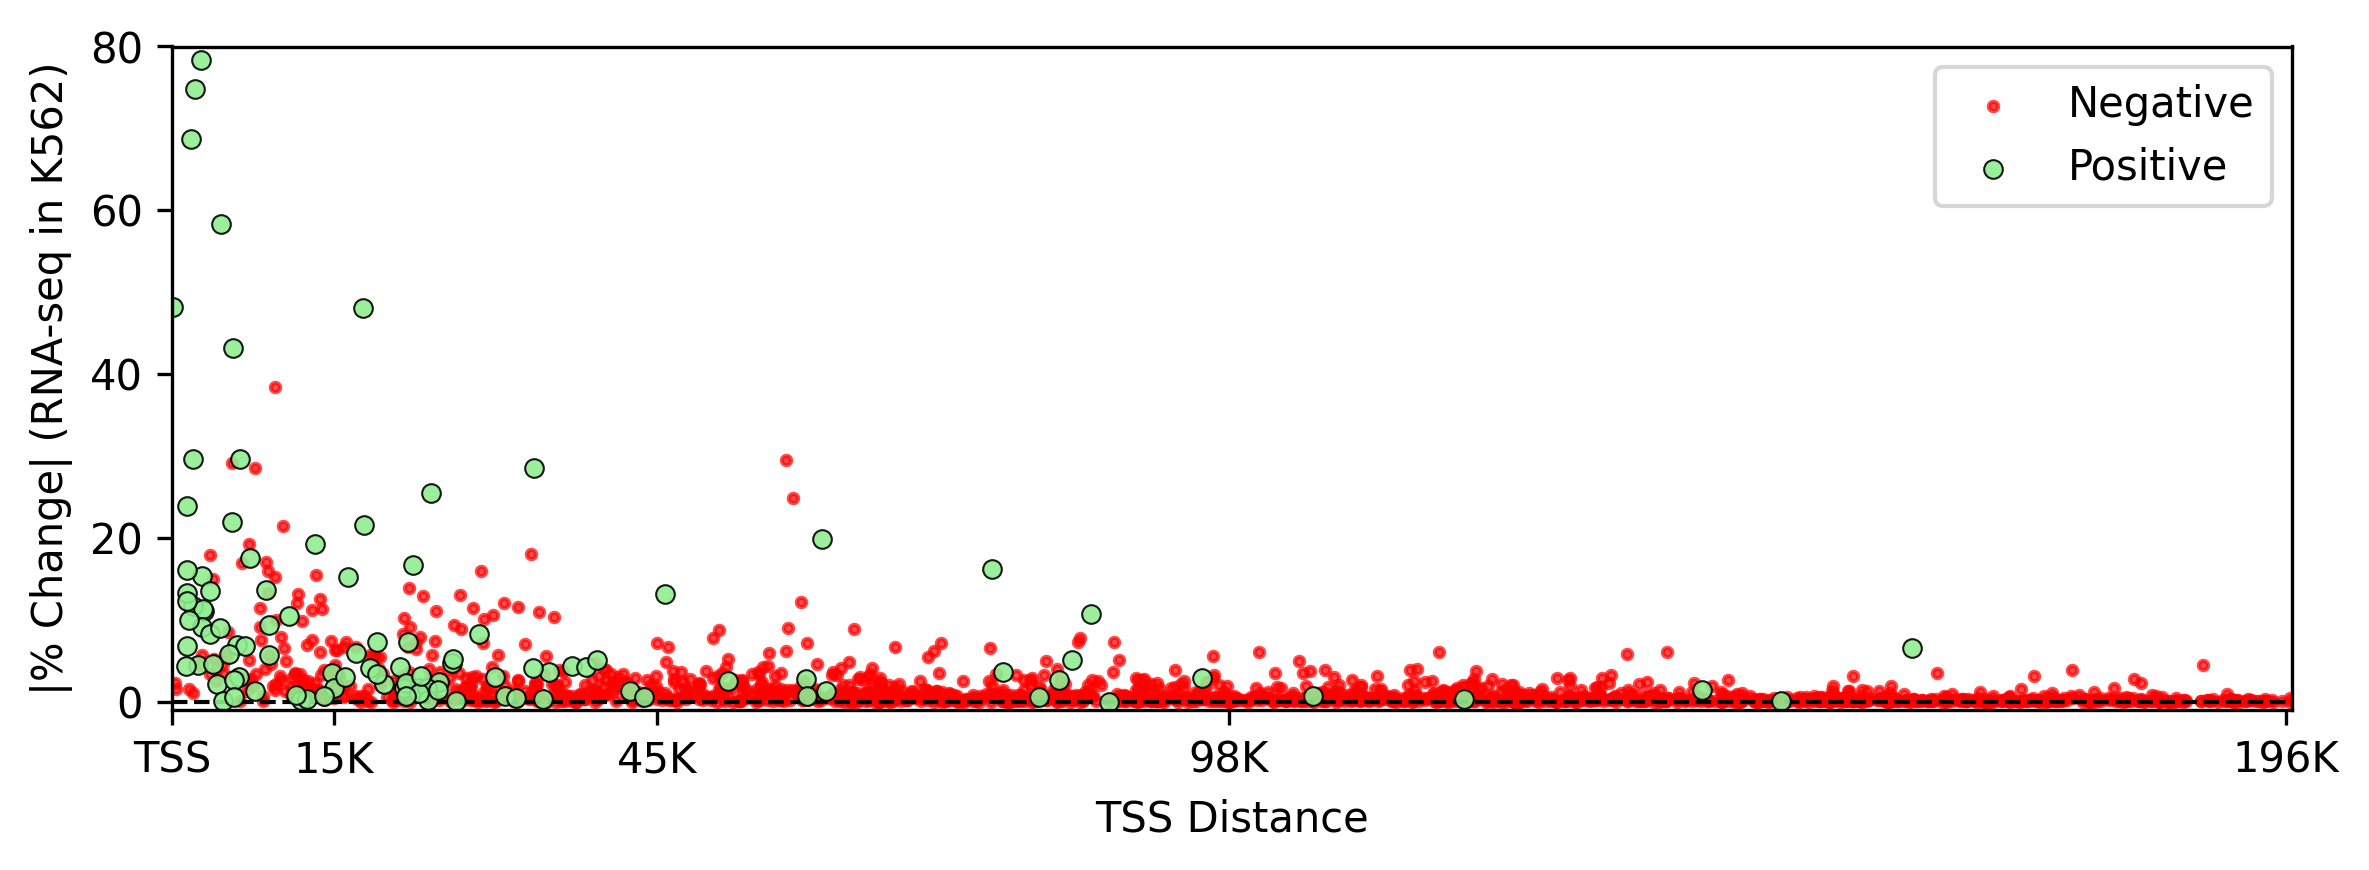

In [7]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; k562_all) --")

#Compute and print accuracy stats
stats_df_miborzoi_k562_all_ism = accuracy_stats(
    crispr_df_miborzoi_k562_all_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_k562_all_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_k562_all_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- mini borzoi scores (ism shuffle; k562_dnase_atac_rna) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	141	47	0.7415	0.5998	0.7813	0.6390	0.6558	0.7449	0.8253	0.4637	0.6120	0.7295
45000	273	40	0.5826	0.1858	0.6536	0.2204	0.4795	0.5842	0.6724	0.1262	0.1932	0.2812
98000	510	14	0.5096	0.1236	0.5075	0.0402	0.3389	0.5085	0.6911	0.0174	0.1284	0.3301
196608	775	5	0.7535	0.0261	0.5745	0.0102	nan	nan	nan	nan	nan	nan
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	141	47	2.6000	1.7944	2.5809	3.9358
45000	273	40	1.1723	0.8202	1.1787	1.6008
98000	510	14	2.0912	0.4555	1.9168	4.5217
196608	775	5	2.0036	nan	nan	nan


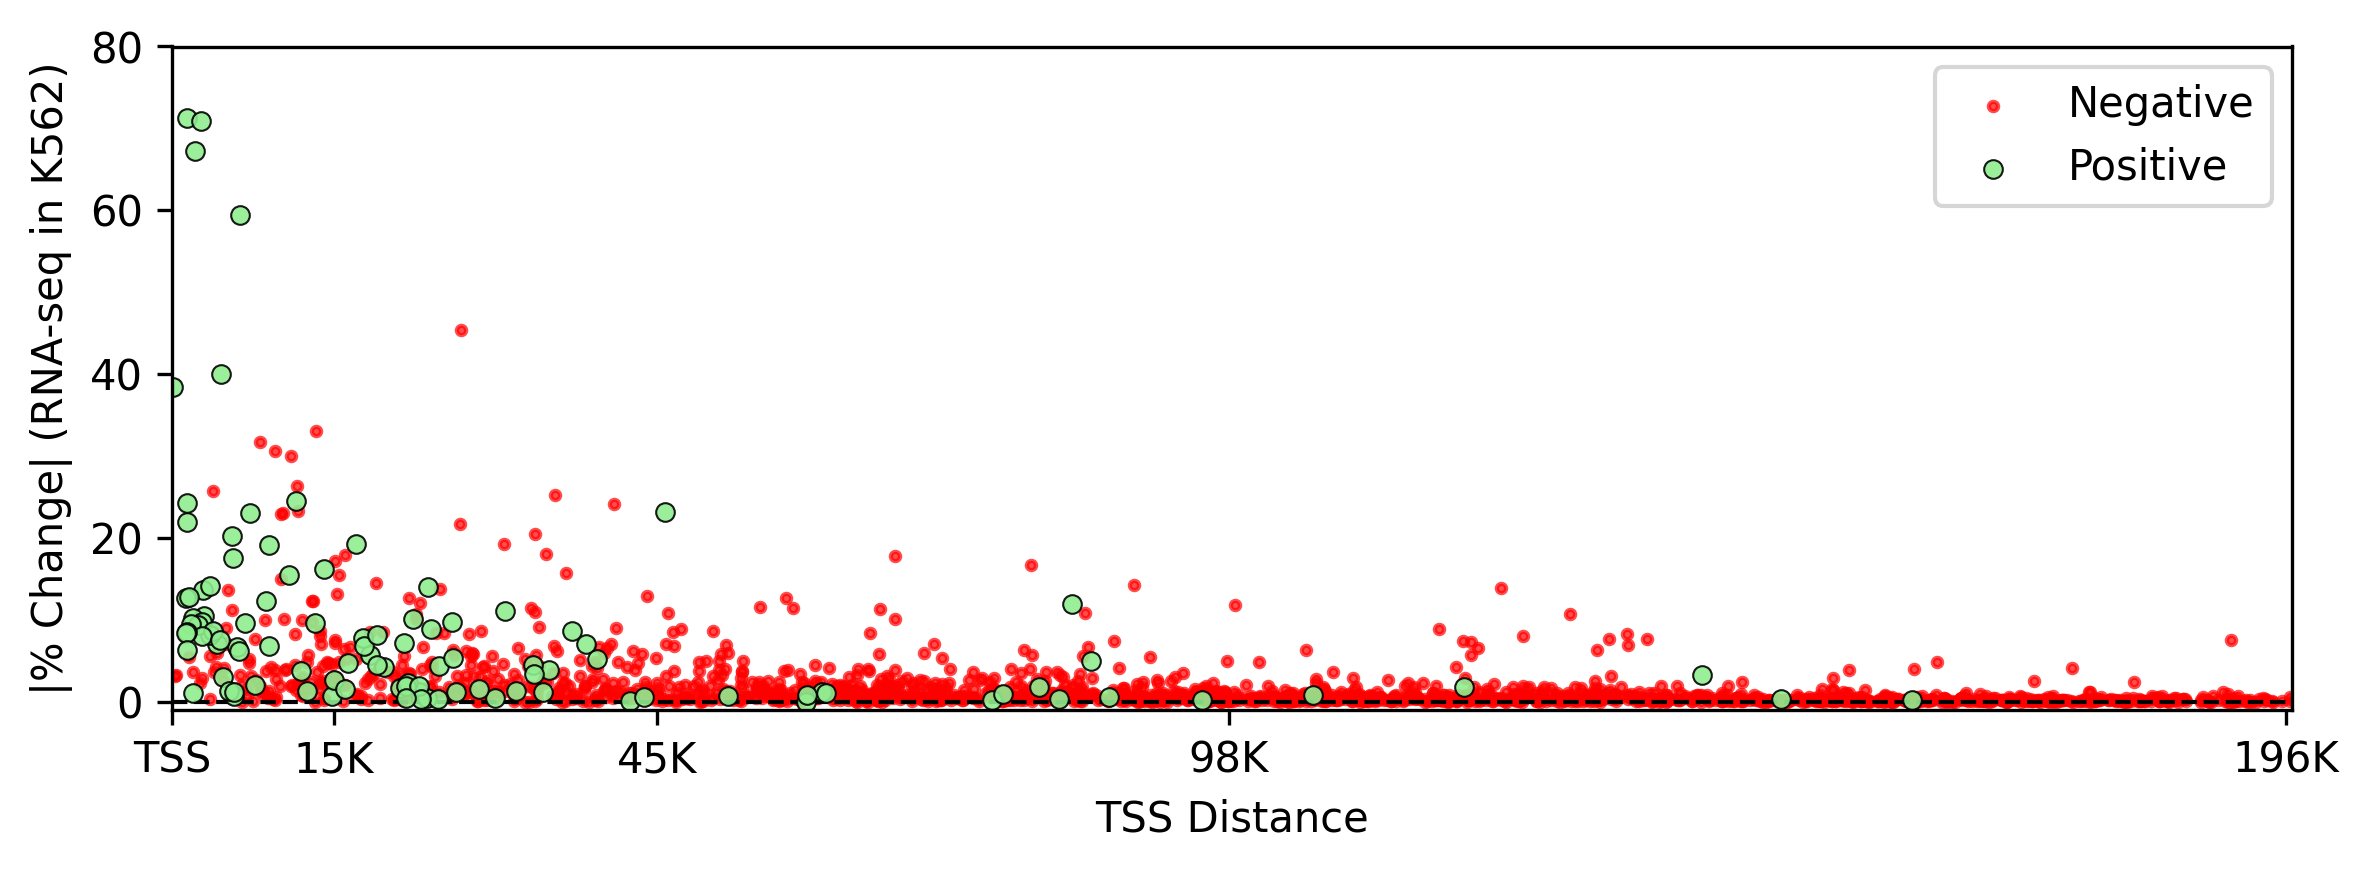

In [8]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; k562_dnase_atac_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_k562_dnase_atac_rna_ism = accuracy_stats(
    crispr_df_miborzoi_k562_dnase_atac_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_k562_dnase_atac_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_k562_dnase_atac_rna_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- mini borzoi scores (ism shuffle; k562_rna) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	141	47	0.6356	0.4707	0.7813	0.6390	0.5362	0.6379	0.7294	0.3551	0.4850	0.6293
45000	273	40	0.6015	0.2572	0.6536	0.2204	0.5001	0.6033	0.7018	0.1595	0.2688	0.4012
98000	510	14	0.4713	0.0552	0.5075	0.0402	0.3241	0.4725	0.6371	0.0172	0.0594	0.2153
196608	775	5	0.6287	0.0119	0.5745	0.0102	nan	nan	nan	nan	nan	nan
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	141	47	1.3800	0.6039	1.3969	3.7550
45000	273	40	2.8543	1.0342	2.7984	6.5048
98000	510	14	1.4346	0.3127	1.3822	3.0436
196608	775	5	1.0459	nan	nan	nan


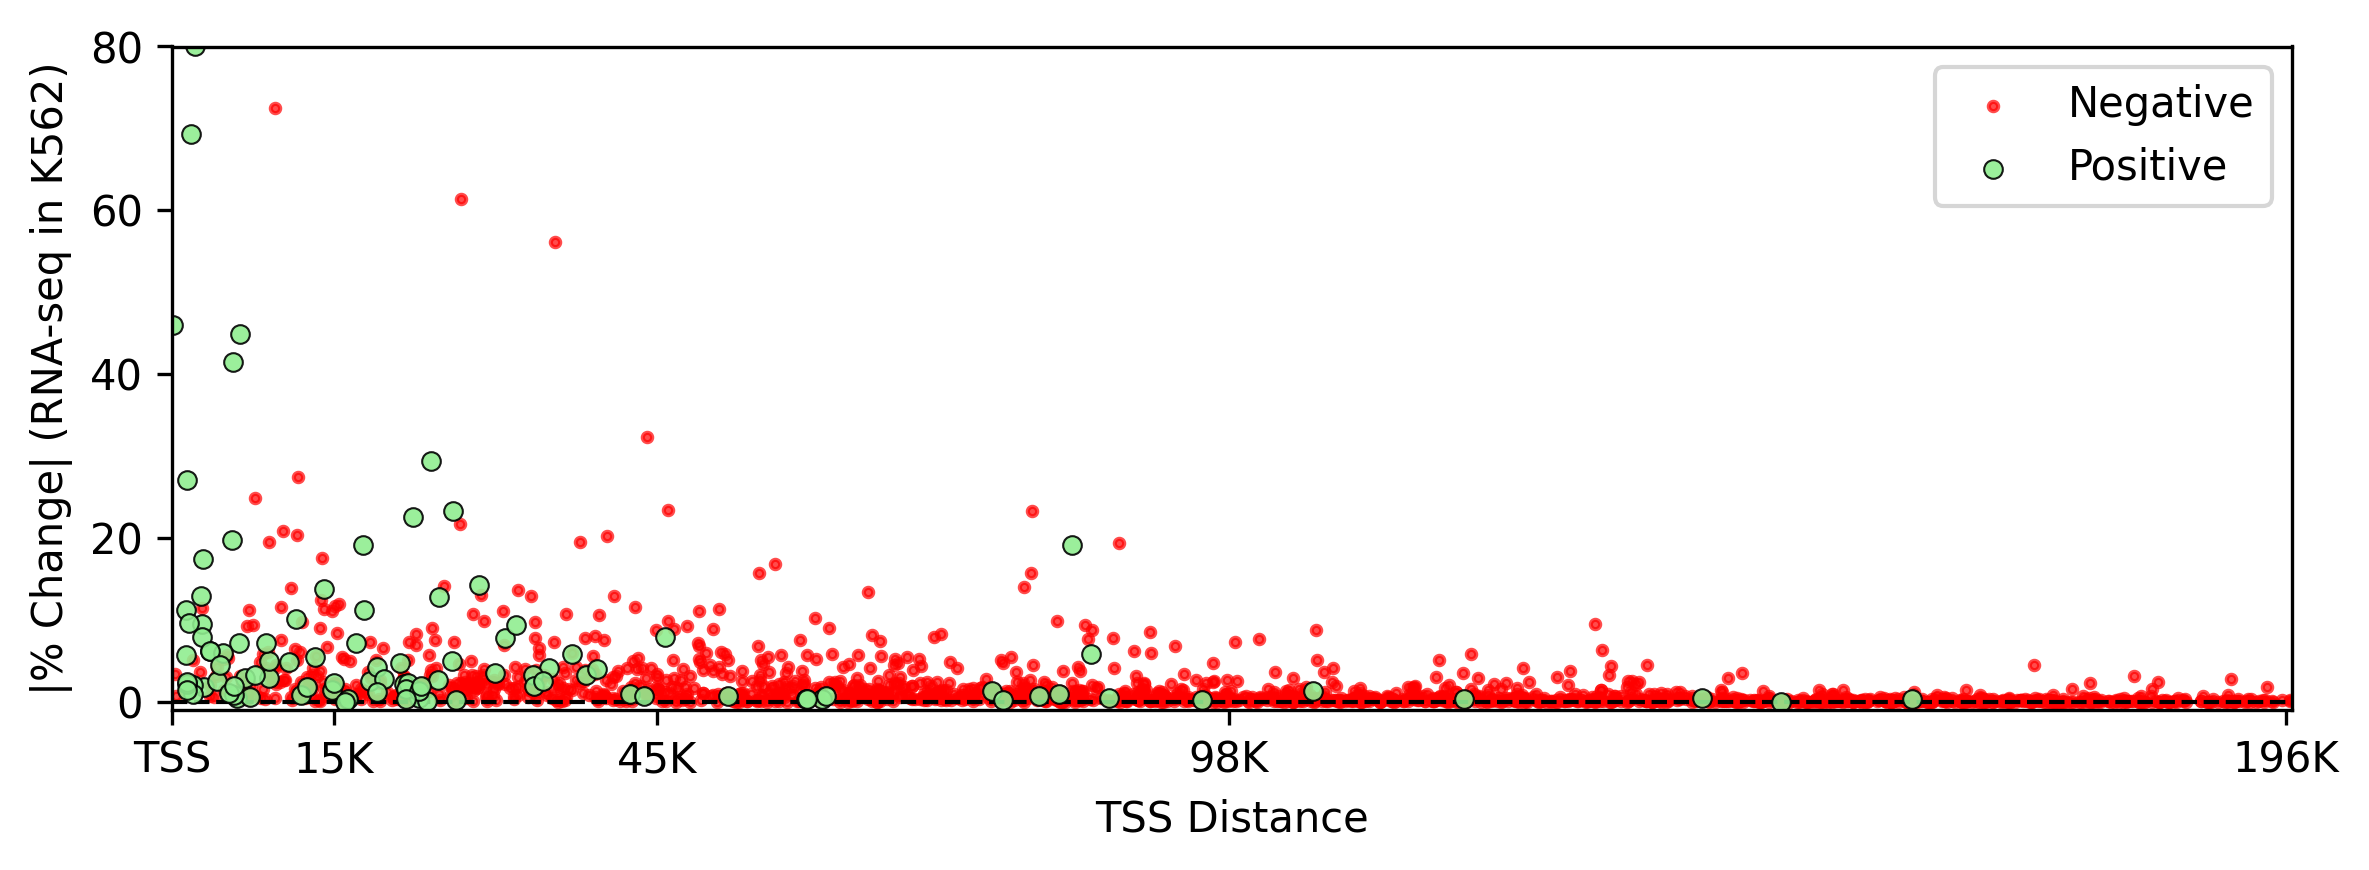

In [9]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; k562_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_k562_rna_ism = accuracy_stats(
    crispr_df_miborzoi_k562_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_k562_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_k562_rna_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- mini borzoi scores (ism shuffle; multisp_dnase_atac_rna) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	141	47	0.8299	0.7869	0.7813	0.6390	0.7448	0.8304	0.9044	0.6745	0.7903	0.8746
45000	273	40	0.7407	0.5164	0.6536	0.2204	0.6388	0.7439	0.8258	0.3596	0.5246	0.6560
98000	510	14	0.5718	0.0523	0.5075	0.0402	0.4059	0.5737	0.7532	0.0210	0.0580	0.1514
196608	775	5	0.7631	0.0641	0.5745	0.0102	nan	nan	nan	nan	nan	nan
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	141	47	3.8076	2.7960	3.7895	5.3517
45000	273	40	3.7049	2.3903	3.6407	5.2975
98000	510	14	1.4937	0.5772	1.4666	2.6229
196608	775	5	3.3554	nan	nan	nan


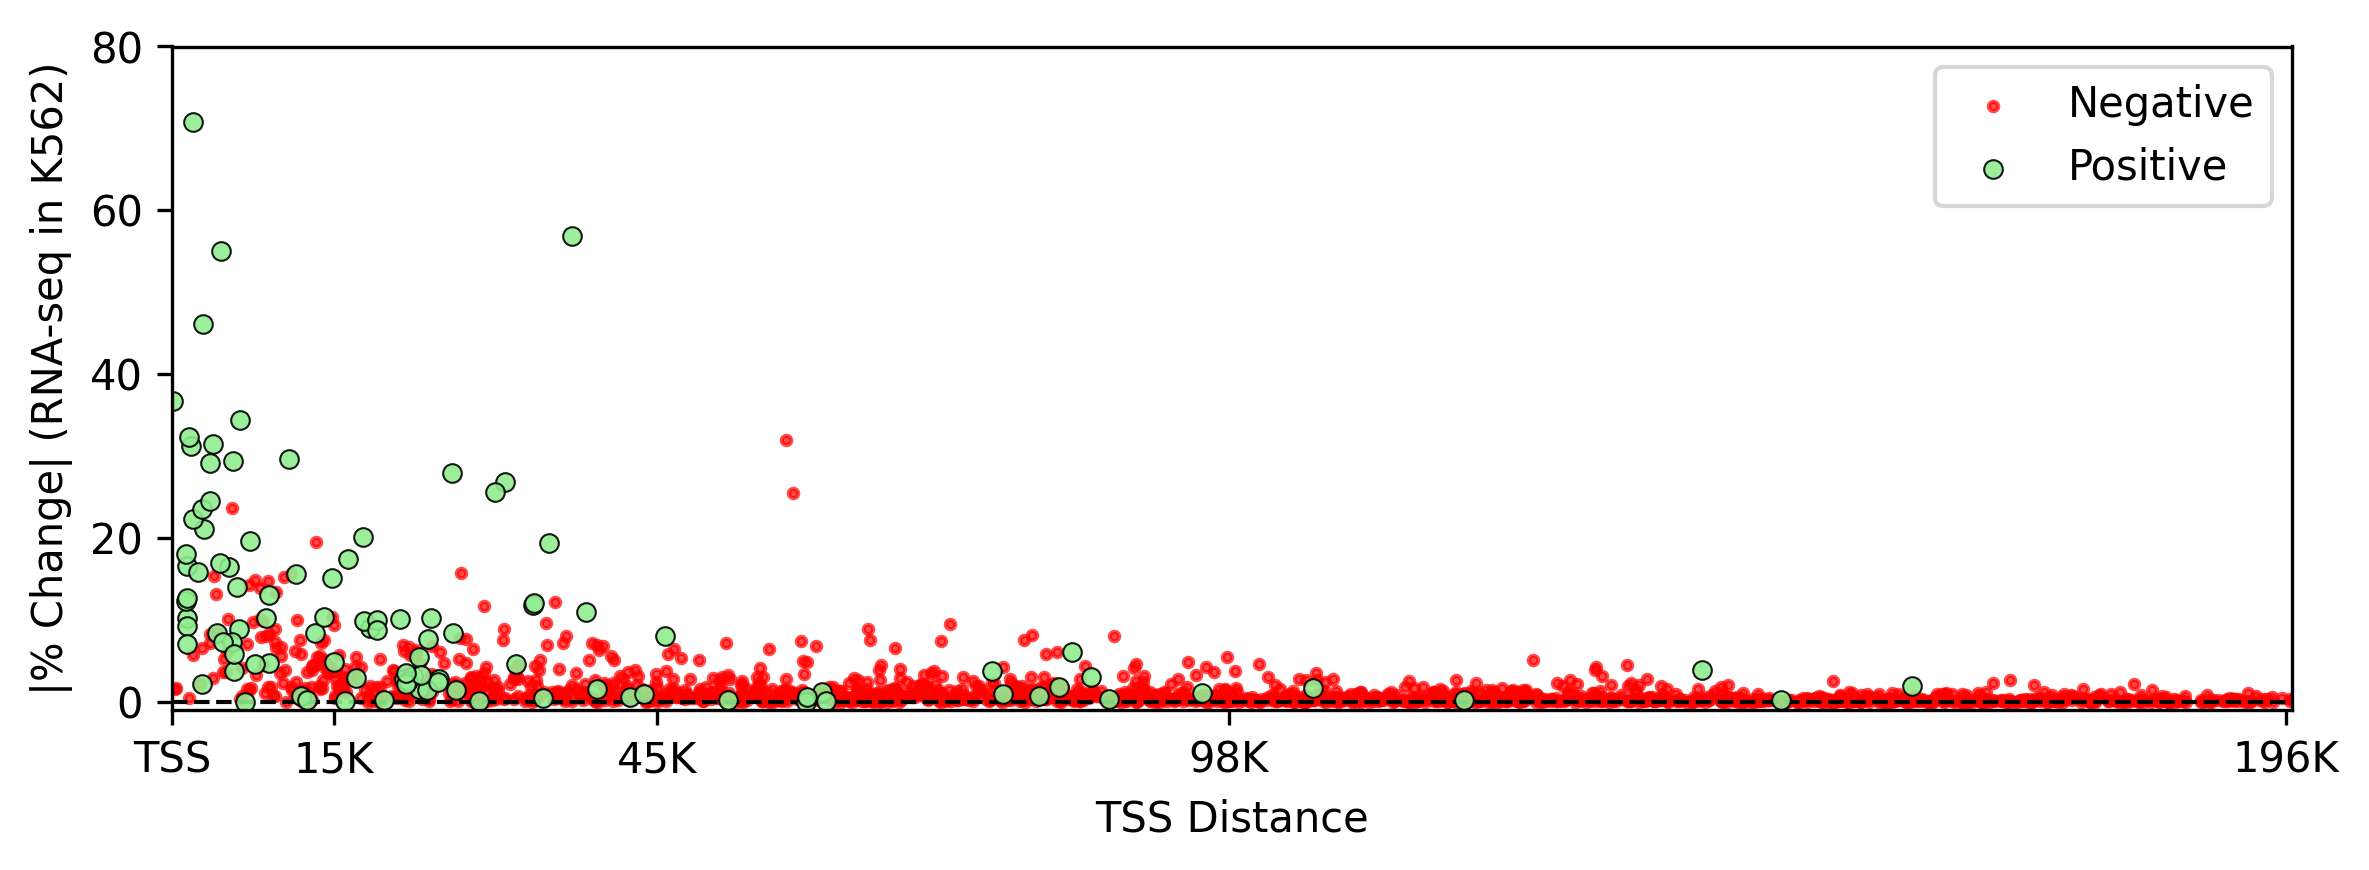

In [10]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; multisp_dnase_atac_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_multisp_dnase_atac_rna_ism = accuracy_stats(
    crispr_df_miborzoi_multisp_dnase_atac_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_multisp_dnase_atac_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_multisp_dnase_atac_rna_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- mini borzoi scores (ism shuffle; multisp_rna) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	141	47	0.6580	0.5585	0.7813	0.6390	0.5603	0.6602	0.7594	0.4300	0.5701	0.6891
45000	273	40	0.5934	0.2069	0.6536	0.2204	0.4922	0.5946	0.6906	0.1382	0.2203	0.3285
98000	510	14	0.4497	0.0503	0.5075	0.0402	0.2799	0.4480	0.6232	0.0163	0.0583	0.1941
196608	775	5	0.6173	0.0134	0.5745	0.0102	nan	nan	nan	nan	nan	nan
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	141	47	2.5721	1.6326	2.5309	3.7900
45000	273	40	1.3405	0.9485	1.3501	1.8313
98000	510	14	1.3565	0.4045	1.2639	2.7835
196608	775	5	1.2751	nan	nan	nan


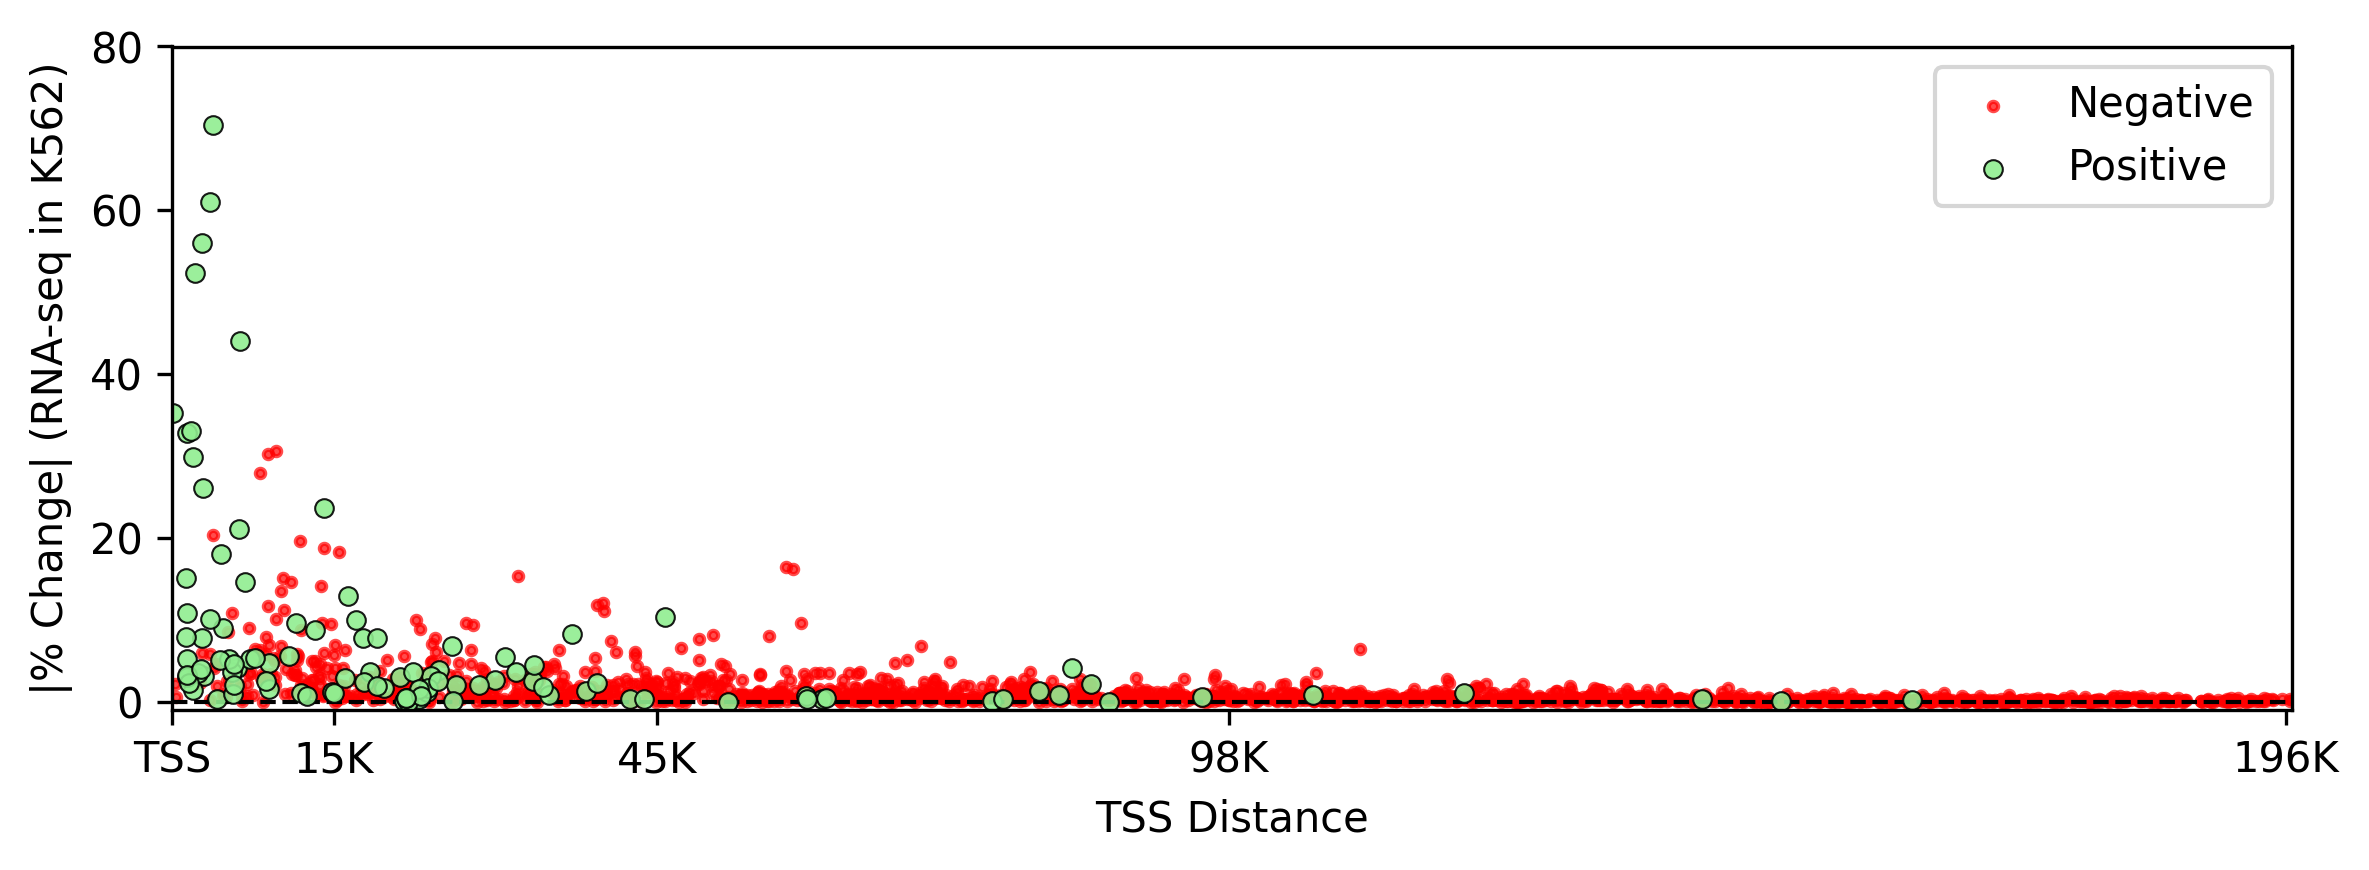

In [11]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; multisp_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_multisp_rna_ism = accuracy_stats(
    crispr_df_miborzoi_multisp_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_multisp_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_multisp_rna_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- mini borzoi scores (ism shuffle; multisp_no_unet) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	141	47	0.7911	0.7182	0.7813	0.6390	0.7105	0.7938	0.8685	0.5836	0.7317	0.8308
45000	273	40	0.7414	0.4617	0.6536	0.2204	0.6507	0.7415	0.8277	0.3201	0.4719	0.6068
98000	510	14	0.5943	0.0851	0.5075	0.0402	0.4168	0.5944	0.7707	0.0265	0.0957	0.2435
196608	775	5	0.6808	0.0204	0.5745	0.0102	nan	nan	nan	nan	nan	nan
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	141	47	4.1564	2.6710	4.1756	6.5861
45000	273	40	4.1517	2.5375	4.1336	6.3389
98000	510	14	3.0401	1.0418	3.0590	5.7310
196608	775	5	1.7701	nan	nan	nan


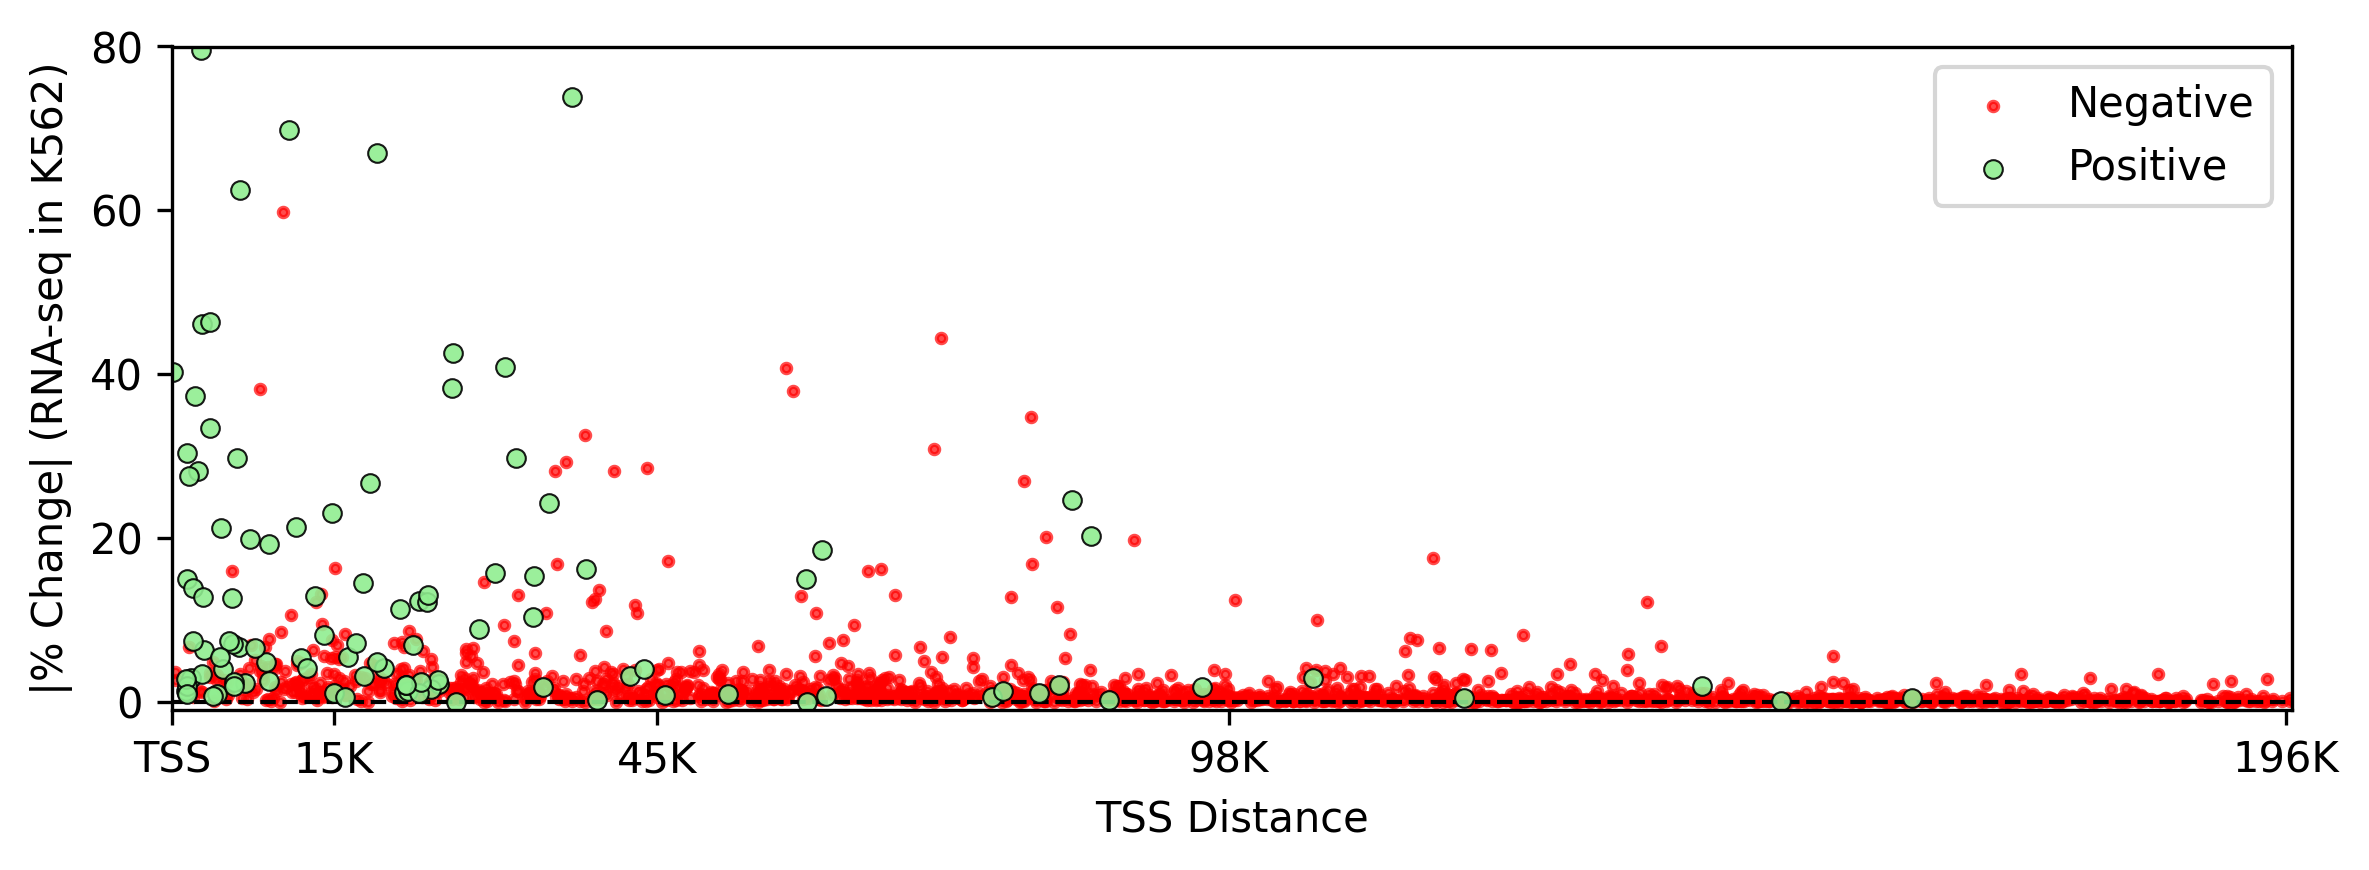

In [12]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; multisp_no_unet) --")

#Compute and print accuracy stats
stats_df_miborzoi_multisp_no_unet_ism = accuracy_stats(
    crispr_df_miborzoi_multisp_no_unet_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_multisp_no_unet_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_multisp_no_unet_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- borzoi scores (ism shuffle) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	141	47	0.7352	0.6656	0.7813	0.6390	0.6359	0.7354	0.8222	0.5396	0.6748	0.7781
45000	273	40	0.7823	0.5714	0.6536	0.2204	0.6944	0.7817	0.8605	0.4098	0.5746	0.7111
98000	510	14	0.5873	0.1837	0.5075	0.0402	0.3593	0.5824	0.7766	0.0395	0.1963	0.4449
196608	807	5	0.8332	0.2651	0.5845	0.0100	nan	nan	nan	nan	nan	nan
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	141	47	4.0092	2.5092	3.9737	6.1309
45000	273	40	4.4780	2.8394	4.4095	6.8302
98000	510	14	2.8333	1.0758	2.7947	4.9838
196608	807	5	8.7266	nan	nan	nan


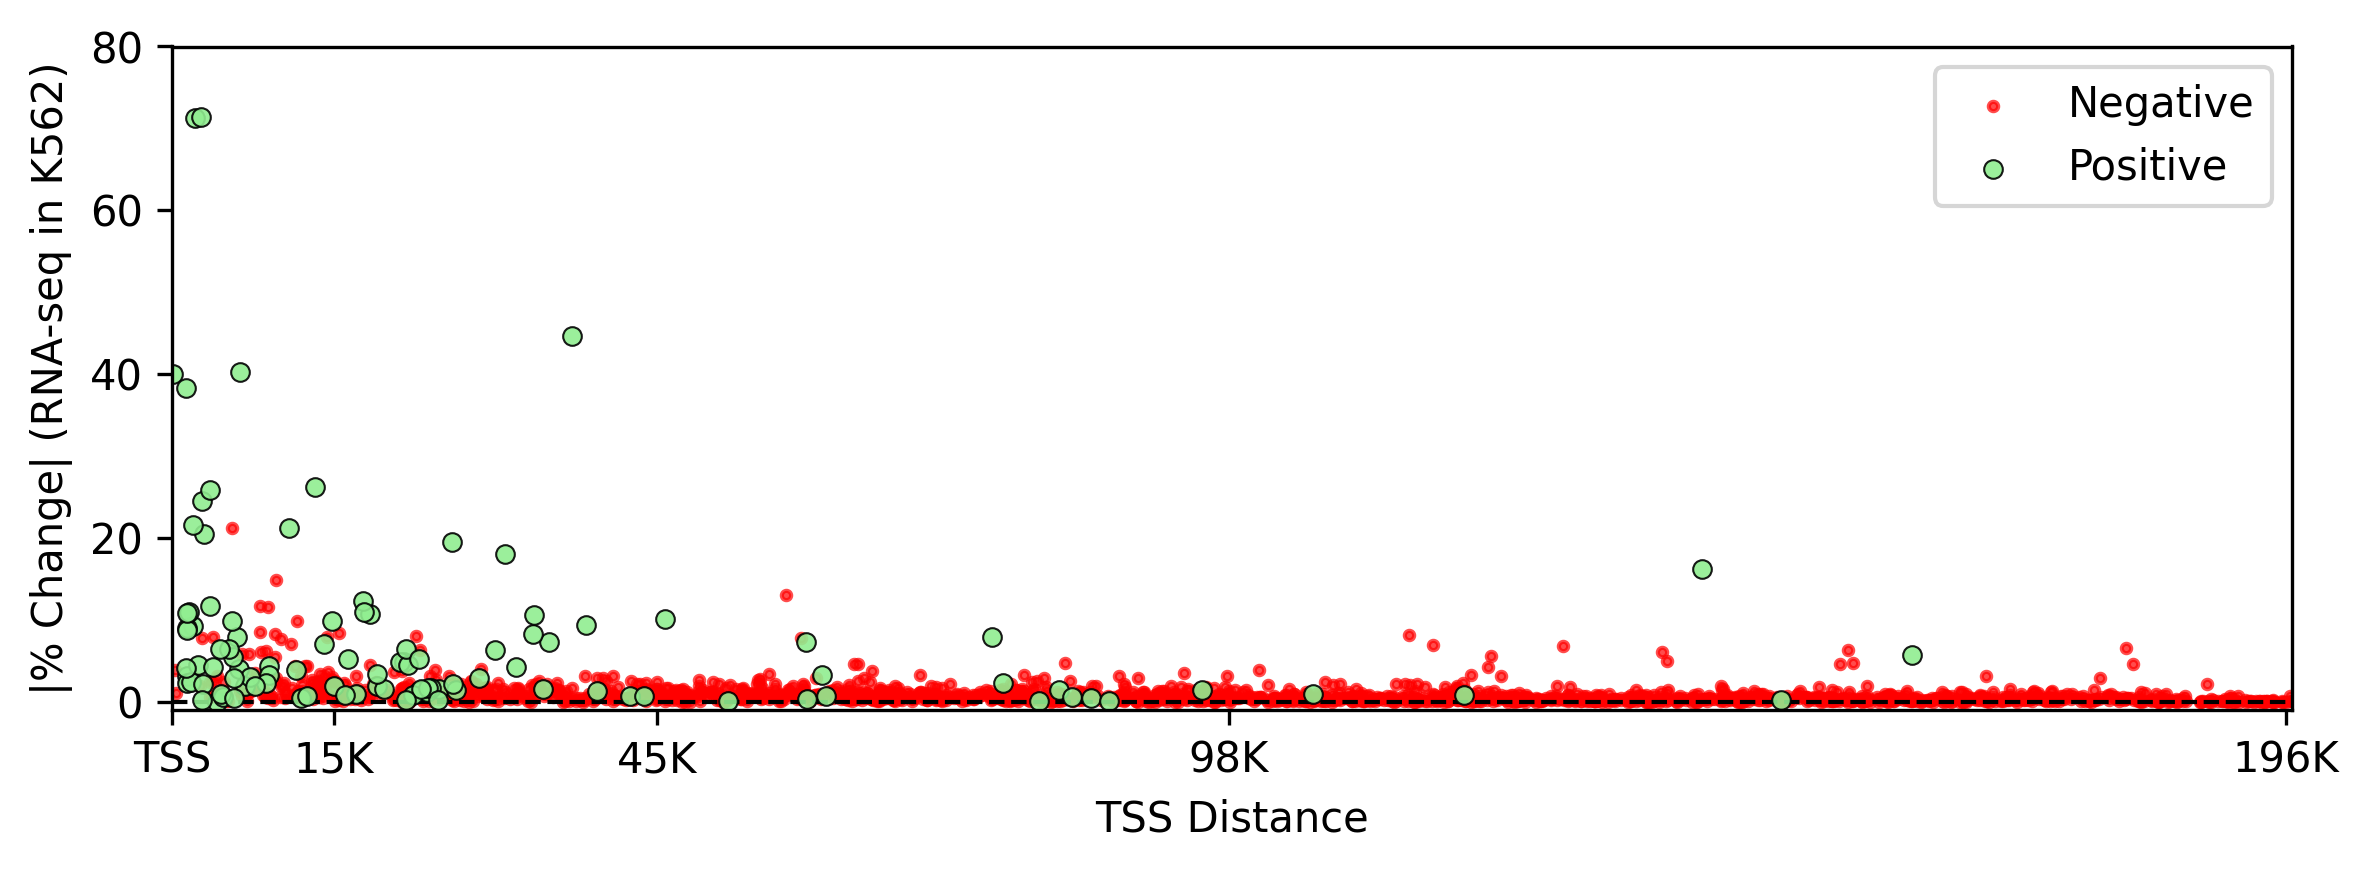

In [13]:
#Evaluate borzoi scores (ism shuffle; ensemble)

print("-- borzoi scores (ism shuffle) --")

#Compute and print accuracy stats
stats_df_borzoi_ism = accuracy_stats(
    crispr_df_borzoi_ensemble_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_borzoi_ensemble_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_borzoi_ensemble_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


In [14]:
#Create stats dataframes for TSS baseline (no bootstrapping)

#Standard baseline
stats_df_tss = stats_df_miborzoi_k562_all_grad_gaussian[['dist', 'sites', 'pos', 'tss_auc', 'tss_ap']].copy()

stats_df_tss['auc'] = stats_df_tss['tss_auc']
stats_df_tss['ap'] = stats_df_tss['tss_ap']
stats_df_tss['auc_lo'] = stats_df_tss['auc']
stats_df_tss['auc_med'] = stats_df_tss['auc']
stats_df_tss['auc_hi'] = stats_df_tss['auc']
stats_df_tss['ap_lo'] = stats_df_tss['ap']
stats_df_tss['ap_med'] = stats_df_tss['ap']
stats_df_tss['ap_hi'] = stats_df_tss['ap']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


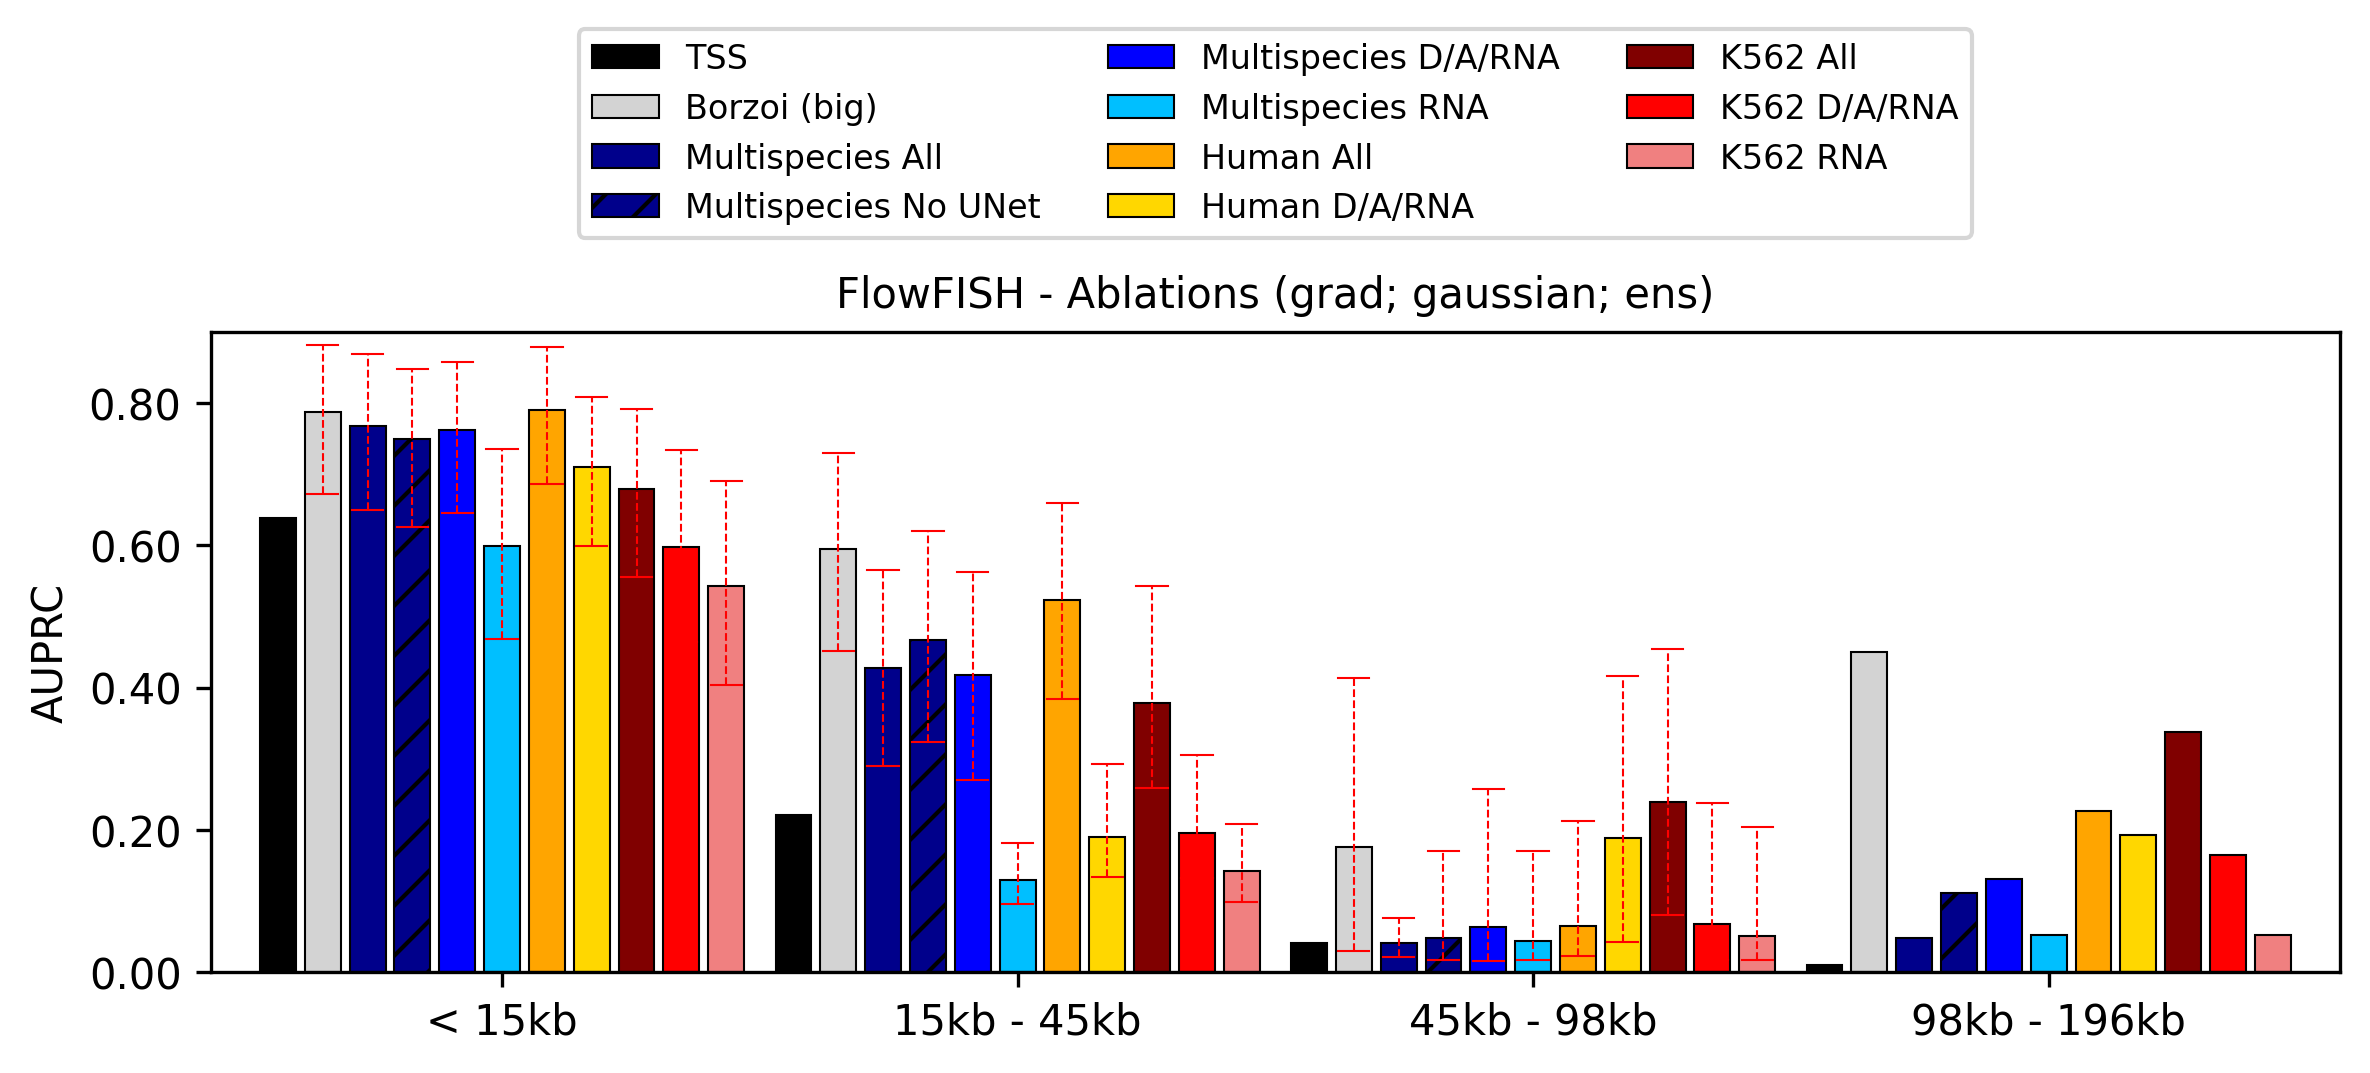

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


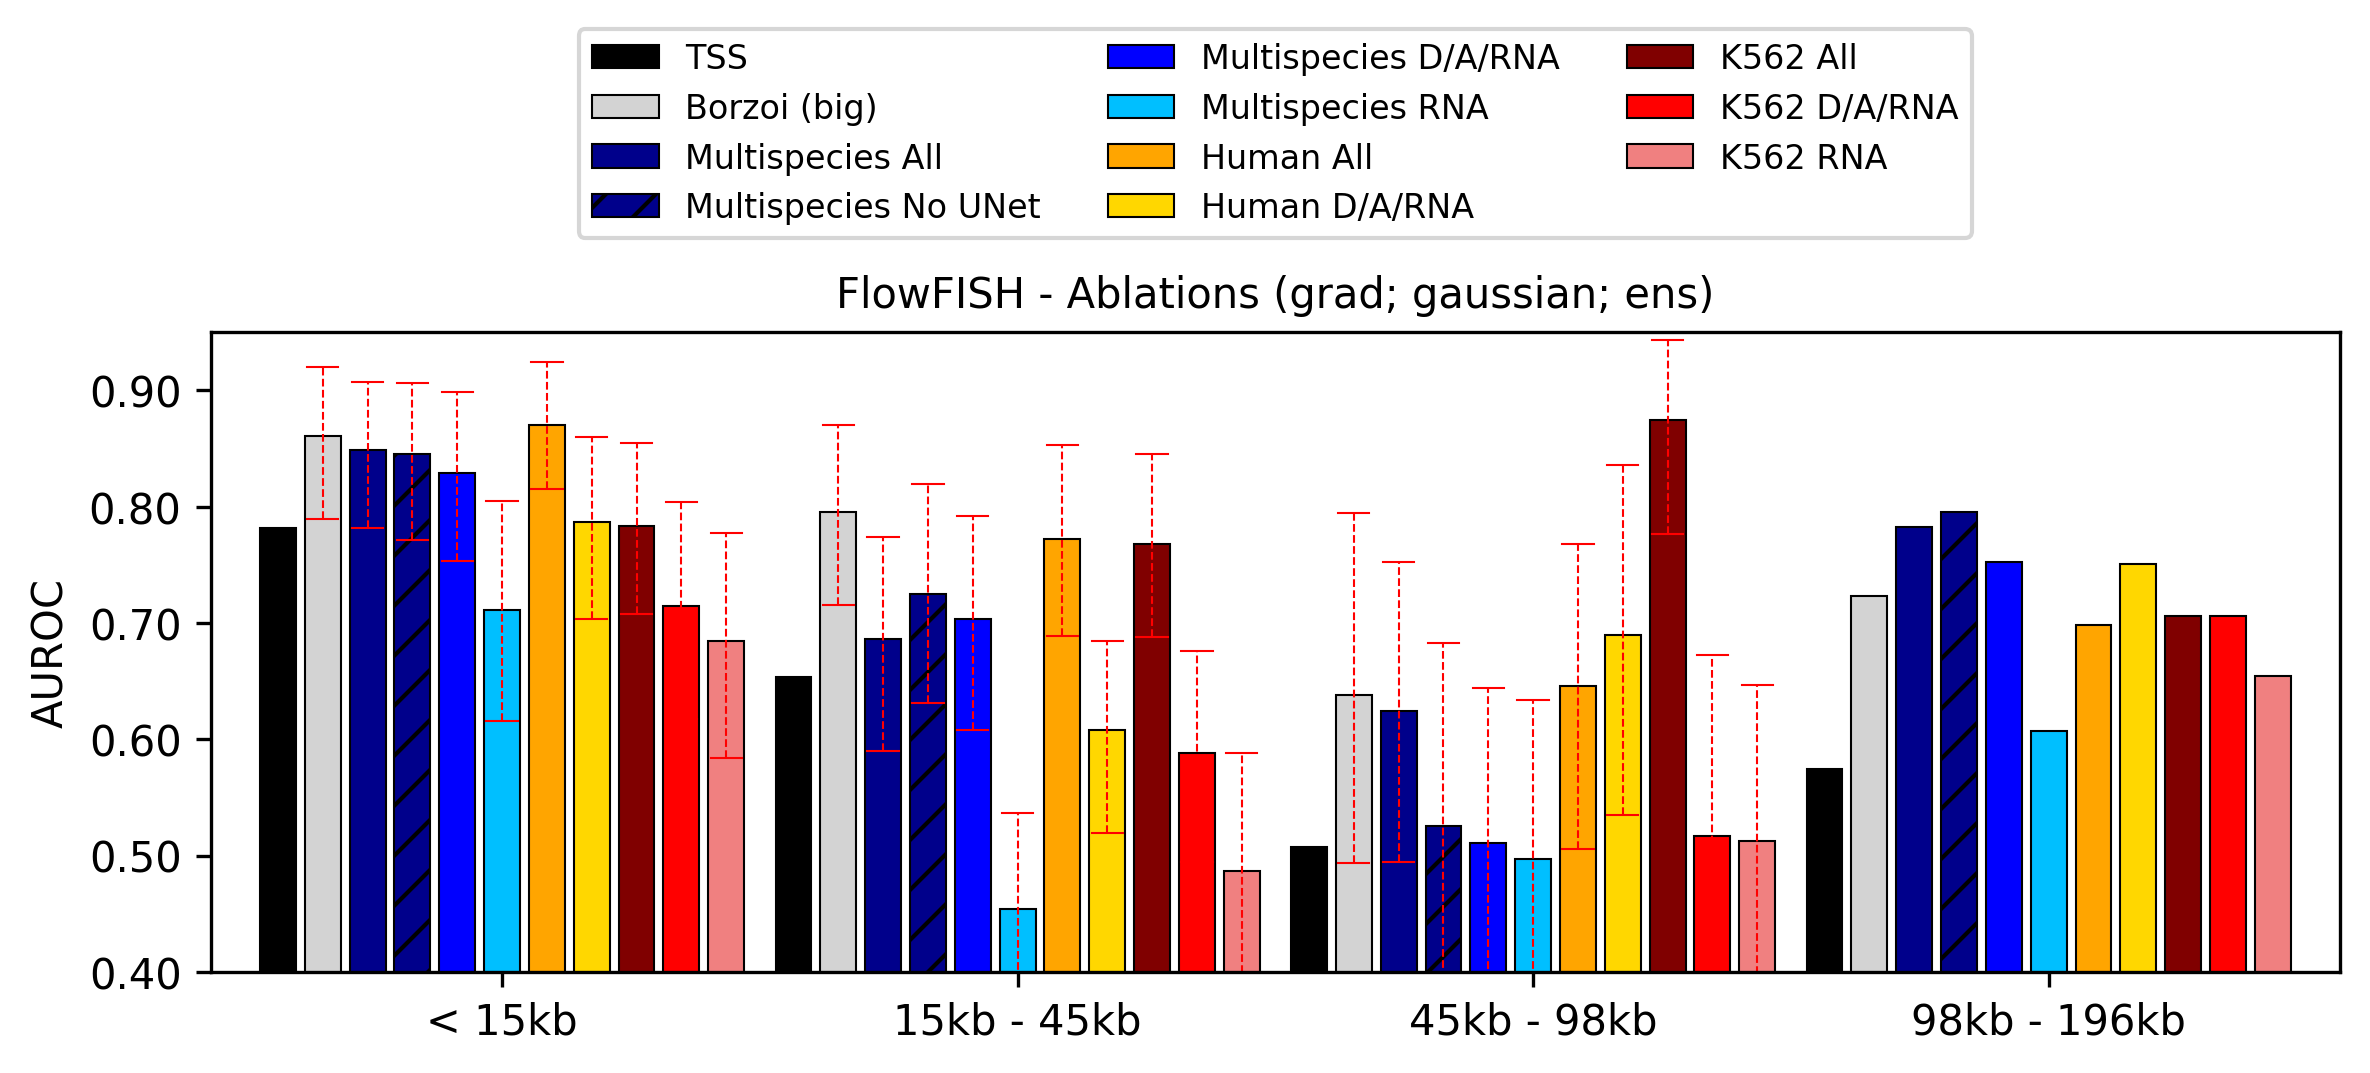

In [15]:
#Plot AUPRC bar chart with perfomance metrics (mini borzoi ablations); gradients

#Model names
model_names = [
    'TSS',
    'Borzoi (big)',
    'Multispecies All',
    'Multispecies No UNet',
    'Multispecies D/A/RNA',
    'Multispecies RNA',
    'Human All',
    'Human D/A/RNA',
    'K562 All',
    'K562 D/A/RNA',
    'K562 RNA',
]

#Stats dataframes
model_dfs = [
    stats_df_tss,
    stats_df_borzoi_grad_gaussian,
    stats_df_miborzoi_baseline_grad_gaussian,
    stats_df_miborzoi_multisp_no_unet_grad_gaussian,
    stats_df_miborzoi_multisp_dnase_atac_rna_grad_gaussian,
    stats_df_miborzoi_multisp_rna_grad_gaussian,
    stats_df_miborzoi_human_all_grad_gaussian,
    stats_df_miborzoi_human_dnase_atac_rna_grad_gaussian,
    stats_df_miborzoi_k562_all_grad_gaussian,
    stats_df_miborzoi_k562_dnase_atac_rna_grad_gaussian,
    stats_df_miborzoi_k562_rna_grad_gaussian,
]

#Model colors
model_colors = [
    'black',
    'lightgray',
    'darkblue',
    'darkblue',
    'blue',
    'deepskyblue',
    'orange',
    'gold',
    'maroon',
    'red',
    'lightcoral',
]

#Model hatch texture
model_hatches = [
    None,
    None,
    None,
    '//',
    None,
    None,
    None,
    None,
    None,
    None,
    None,
]

plot_bars(
    model_names,
    model_dfs,
    model_colors,
    model_hatches=model_hatches,
    limit_x=True,
    legend_outside=True,
    fig_size=(8, 4.25),
    plot_title='FlowFISH - Ablations (grad; gaussian; ens)',
    metric='ap',
    metric_str='AUPRC',
    distances=[15000, 45000, 98000, 196000],
    distance_strs=['< 15kb', '15kb - 45kb', '45kb - 98kb', '98kb - 196kb'],
    y_min=0.0,
    y_max=0.9,
    save_name='flowfish_miborzoi_grad_bench_prc_w_borzoi'
)

#Plot AUROC bar chart

plot_bars(
    model_names,
    model_dfs,
    model_colors,
    model_hatches=model_hatches,
    limit_x=True,
    legend_outside=True,
    fig_size=(8, 4.25),
    plot_title='FlowFISH - Ablations (grad; gaussian; ens)',
    metric='auc',
    metric_str='AUROC',
    distances=[15000, 45000, 98000, 196000],
    distance_strs=['< 15kb', '15kb - 45kb', '45kb - 98kb', '98kb - 196kb'],
    y_min=0.4,
    y_max=0.95,
    save_name='flowfish_miborzoi_grad_bench_roc_w_borzoi'
)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


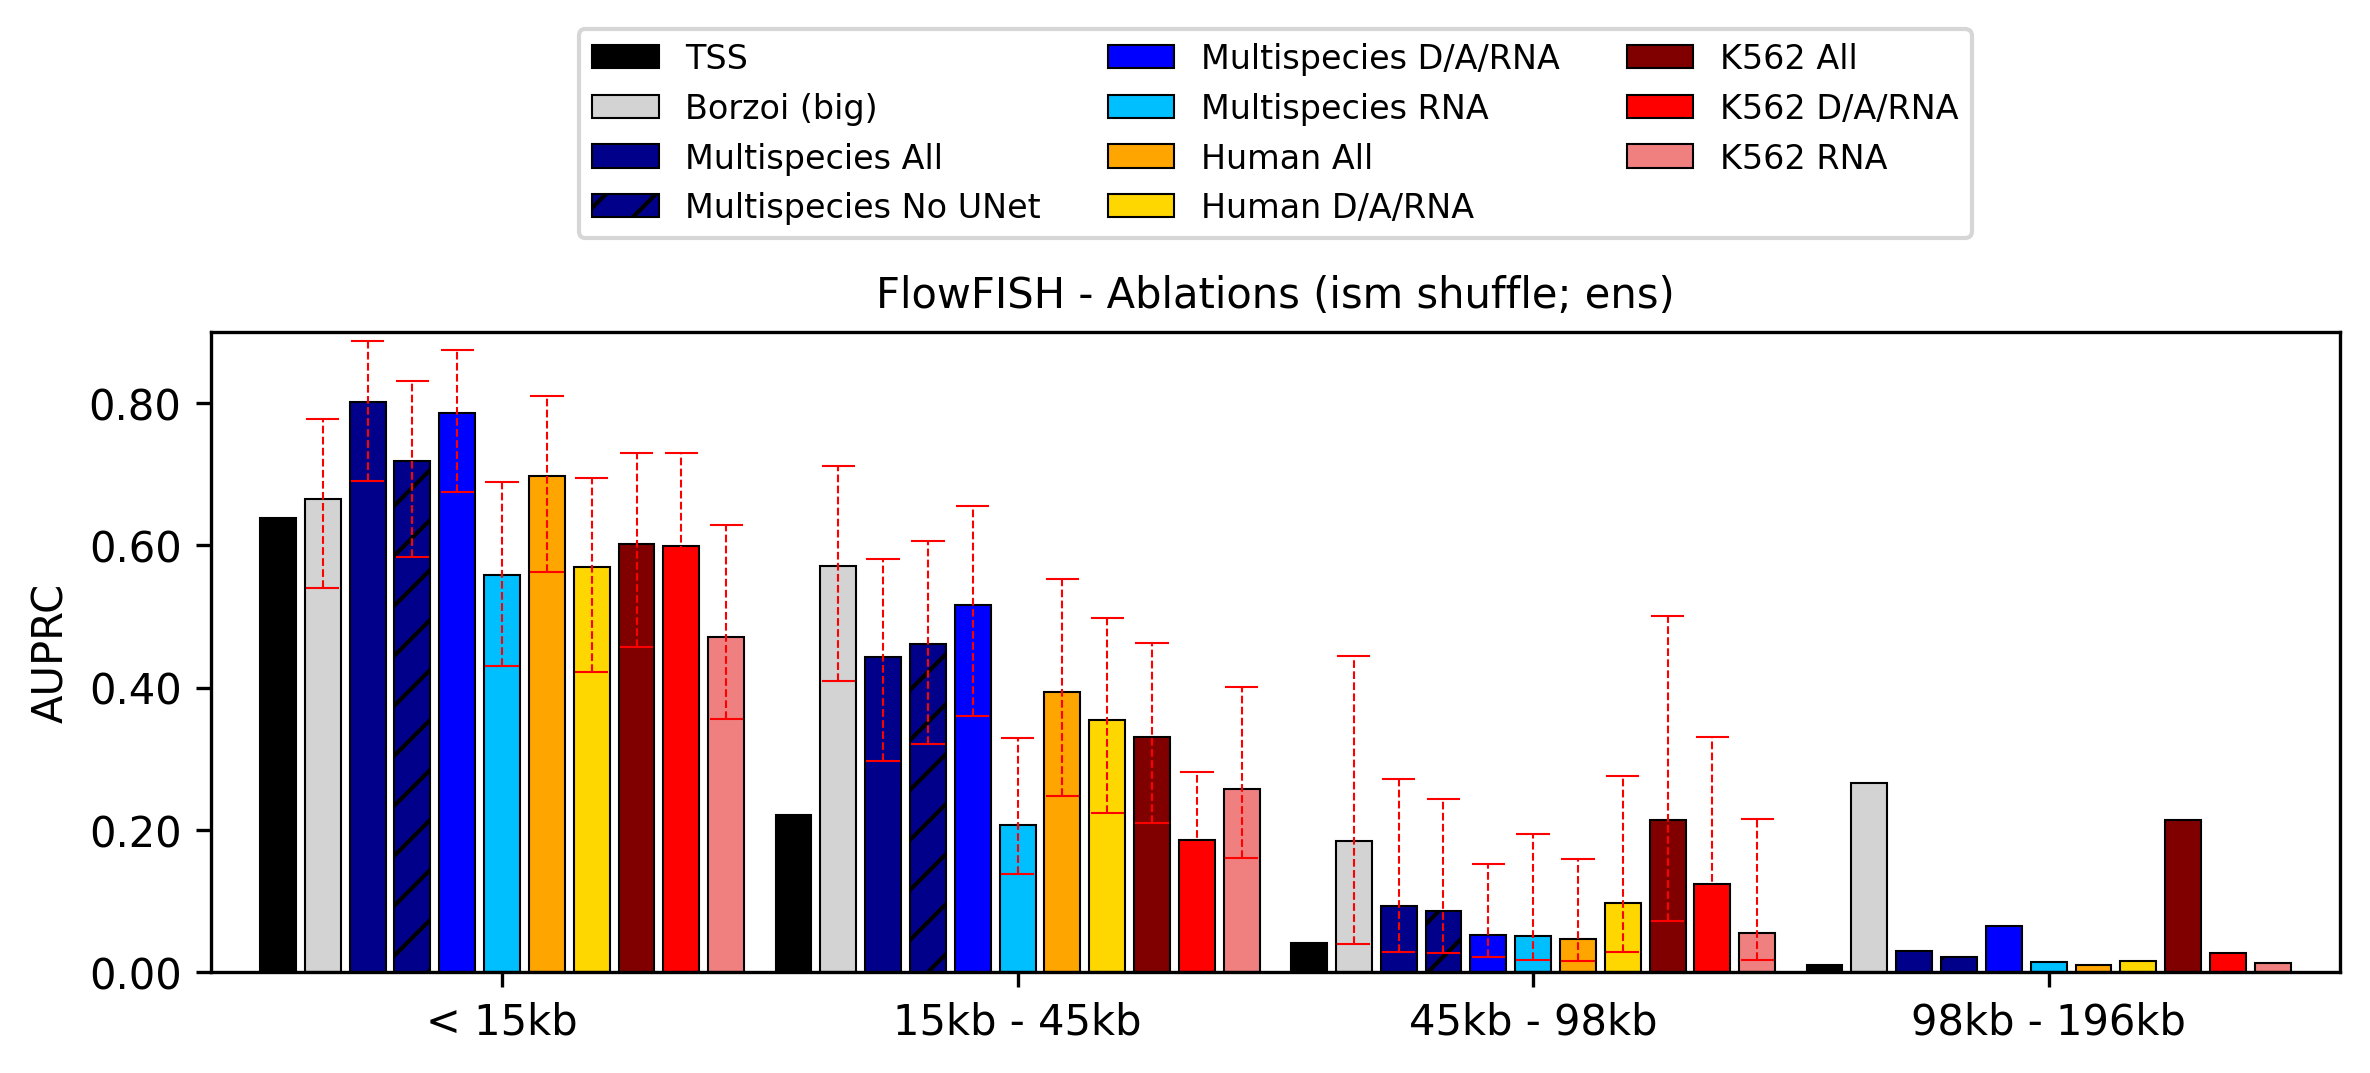

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


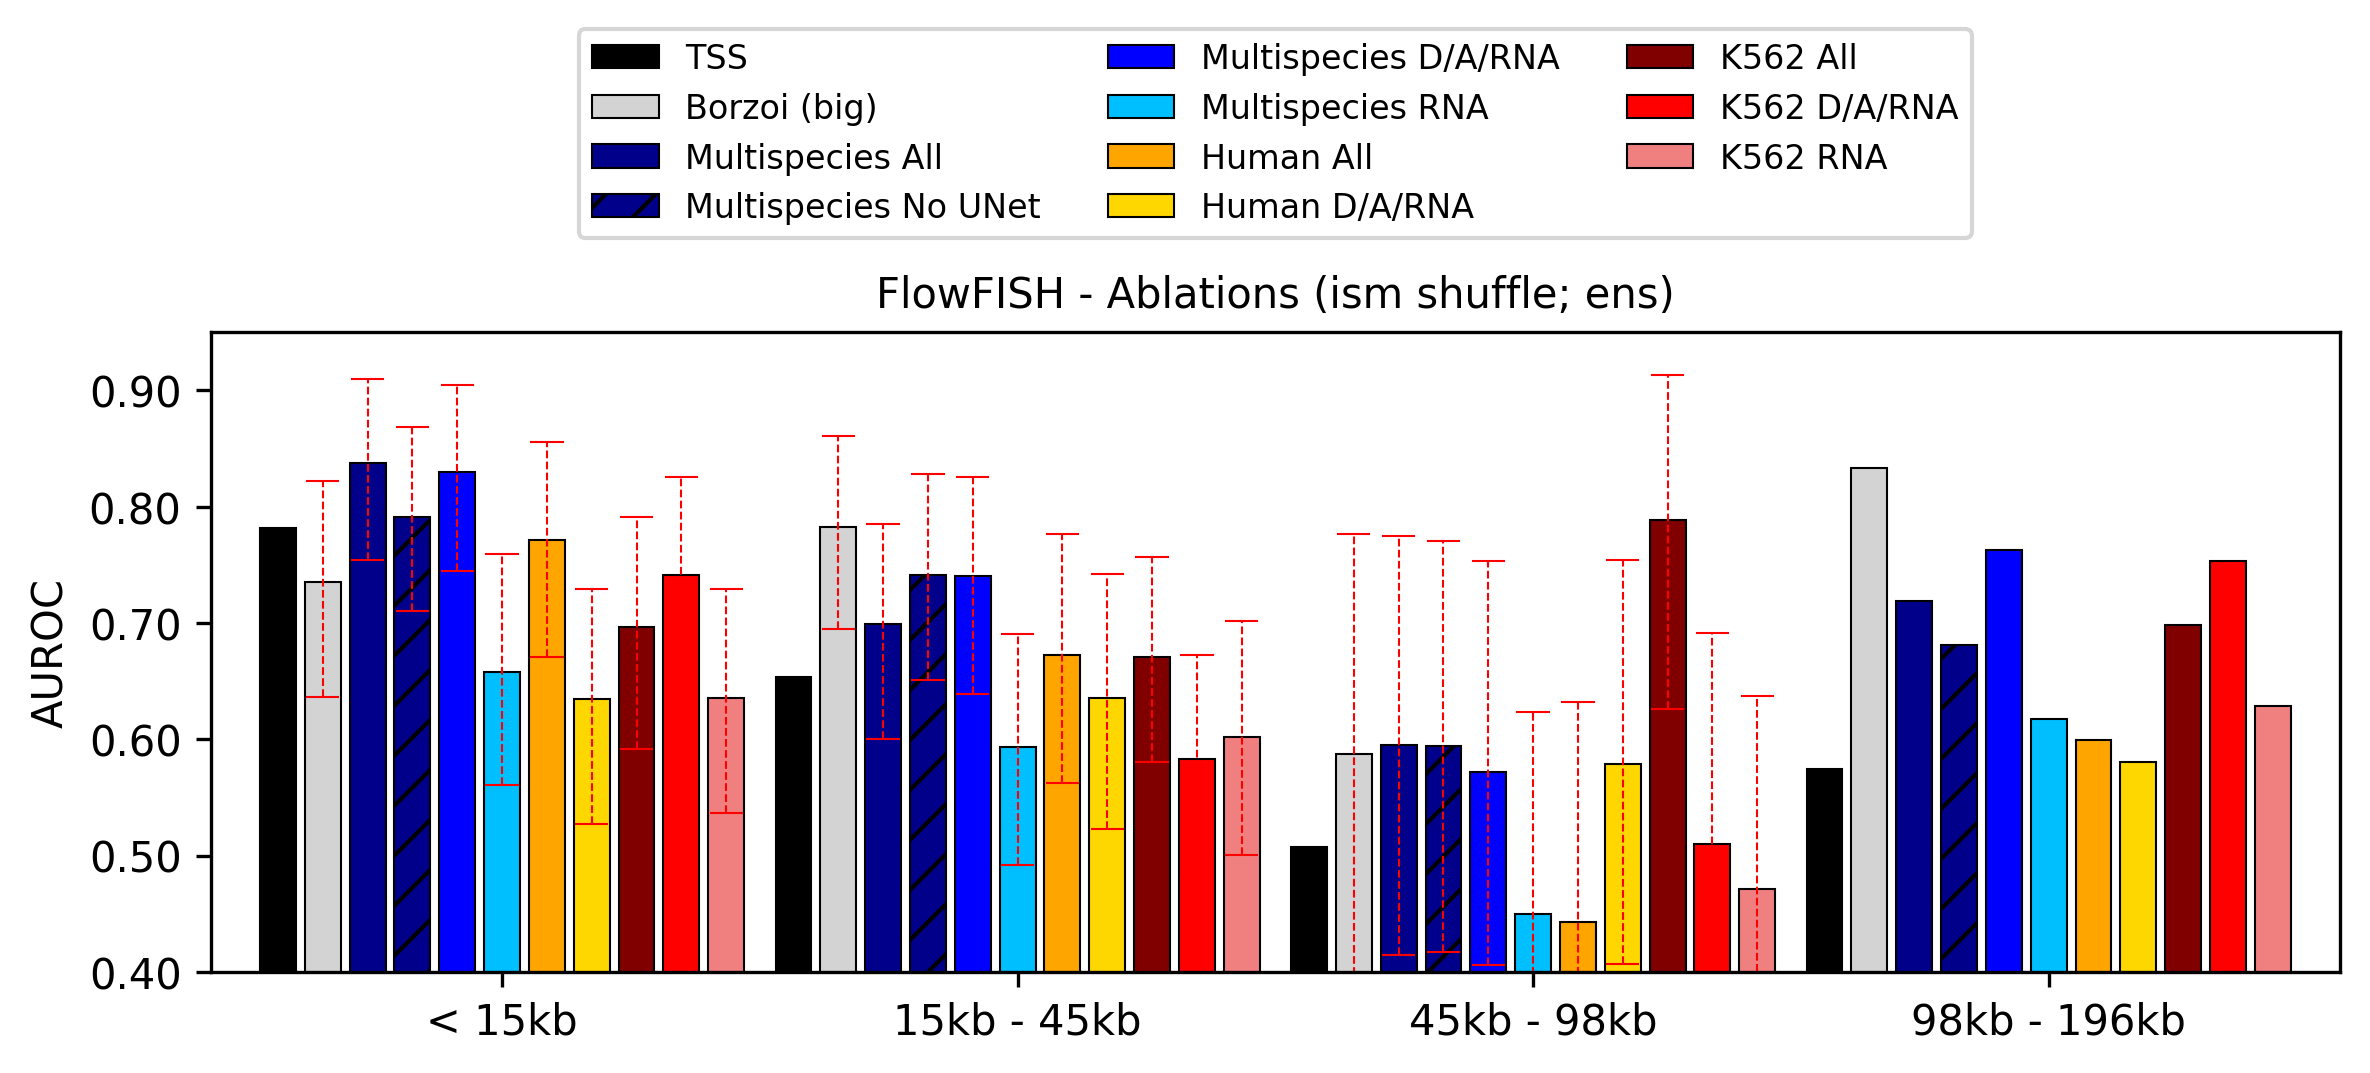

In [16]:
#Plot AUPRC bar chart with perfomance metrics (mini borzoi ablations); ism shuffle

#Model names
model_names = [
    'TSS',
    'Borzoi (big)',
    'Multispecies All',
    'Multispecies No UNet',
    'Multispecies D/A/RNA',
    'Multispecies RNA',
    'Human All',
    'Human D/A/RNA',
    'K562 All',
    'K562 D/A/RNA',
    'K562 RNA',
]

#Stats dataframes
model_dfs = [
    stats_df_tss,
    stats_df_borzoi_ism,
    stats_df_miborzoi_baseline_ism,
    stats_df_miborzoi_multisp_no_unet_ism,
    stats_df_miborzoi_multisp_dnase_atac_rna_ism,
    stats_df_miborzoi_multisp_rna_ism,
    stats_df_miborzoi_human_all_ism,
    stats_df_miborzoi_human_dnase_atac_rna_ism,
    stats_df_miborzoi_k562_all_ism,
    stats_df_miborzoi_k562_dnase_atac_rna_ism,
    stats_df_miborzoi_k562_rna_ism,
]

#Model colors
model_colors = [
    'black',
    'lightgray',
    'darkblue',
    'darkblue',
    'blue',
    'deepskyblue',
    'orange',
    'gold',
    'maroon',
    'red',
    'lightcoral',
]

#Model hatch texture
model_hatches = [
    None,
    None,
    None,
    '//',
    None,
    None,
    None,
    None,
    None,
    None,
    None,
]

plot_bars(
    model_names,
    model_dfs,
    model_colors,
    model_hatches=model_hatches,
    limit_x=True,
    legend_outside=True,
    fig_size=(8, 4.25),
    plot_title='FlowFISH - Ablations (ism shuffle; ens)',
    metric='ap',
    metric_str='AUPRC',
    distances=[15000, 45000, 98000, 196000],
    distance_strs=['< 15kb', '15kb - 45kb', '45kb - 98kb', '98kb - 196kb'],
    y_min=0.0,
    y_max=0.9,
    save_name='flowfish_miborzoi_ism_bench_prc_w_borzoi'
)

#Plot AUROC bar chart

plot_bars(
    model_names,
    model_dfs,
    model_colors,
    model_hatches=model_hatches,
    limit_x=True,
    legend_outside=True,
    fig_size=(8, 4.25),
    plot_title='FlowFISH - Ablations (ism shuffle; ens)',
    metric='auc',
    metric_str='AUROC',
    distances=[15000, 45000, 98000, 196000],
    distance_strs=['< 15kb', '15kb - 45kb', '45kb - 98kb', '98kb - 196kb'],
    y_min=0.4,
    y_max=0.95,
    save_name='flowfish_miborzoi_ism_bench_roc_w_borzoi'
)
